In [1]:
import pandas as pd
pd.set_option('precision', 2)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors_ = plt.get_cmap('Set2')(np.linspace(0, 1, 8))
colors_year = plt.get_cmap('magma')(np.linspace(0.5, 1, 5)[::-1][1:])

from IPython.core.pylabtools import figsize
from IPython.display import display
figsize(8, 5)

%load_ext watermark
%load_ext autoreload
%autoreload 2
%matplotlib inline

%watermark -d -t -u -v -g -r -b -iv -a "Hongsup Shin" 

numpy      1.18.1
pandas     1.0.3
seaborn    0.10.0
matplotlib 3.1.3
Hongsup Shin 
last updated: 2020-08-07 15:03:56 

CPython 3.6.10
IPython 7.13.0
Git hash: af5d72a62837d88fa518c6f9cc5252e73590c3db
Git repo: https://github.com/hongsups/TJI_working_hshin.git
Git branch: master


In [2]:
# loading custom modules
import preprocess
import plot

# Data Insight of TJI's Officer-involved Shootings in Texas Report
This notebook shows the details of the Data Insight section of TJI's Officer-involved Shootings in Texas Report. This notebook is based on the civilian and officer data from TJI's website (downloaded in June 2020), which I preprocessed. The details of the preprocessing is described in `1.0-hs-preprocess_officer_involved_shooting_data.ipynb`. For a comprehensive data summary, check out the notebook, `1.0-hs-data_summary_OIS_report.ipynb`.

# Styling

In [131]:
from matplotlib.colors import LinearSegmentedColormap

In [132]:
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 10

plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.titleweight'] = 'bold'

plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.titlesize'] = 10
plt.rcParams['figure.titleweight'] = 'bold'

plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.edgecolor'] = 'white'

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

In [133]:
cols_race = ['#CE2827', '#3167AE', '#4C5151', '#B8BAB9']
cols_oag_tji = ['#929596', '#000000']
cols_gender = ['#183458', '#9b1f20']
cols_incident_causes = ['#000000', '#4c5151', '#6f7574', '#929596', '#b7bab9']
cols_year = cols_incident_causes[1:][::-1]
cols_deaths_injury = ['#9b1f20', '#183458']
cols_shot_deaths = ['#000000', '#9b1f20']
cols_bar = ['#6f7574']
cols_civilian_officer = ['#9b1f20', '#183458']

# cols_heatmap_minmax = ['#254e84', '#adcedf']
# cm = LinearSegmentedColormap.from_list('test', cols_heatmap_minmax, N=5)

matplotlib.axes._subplots.AxesSubplot

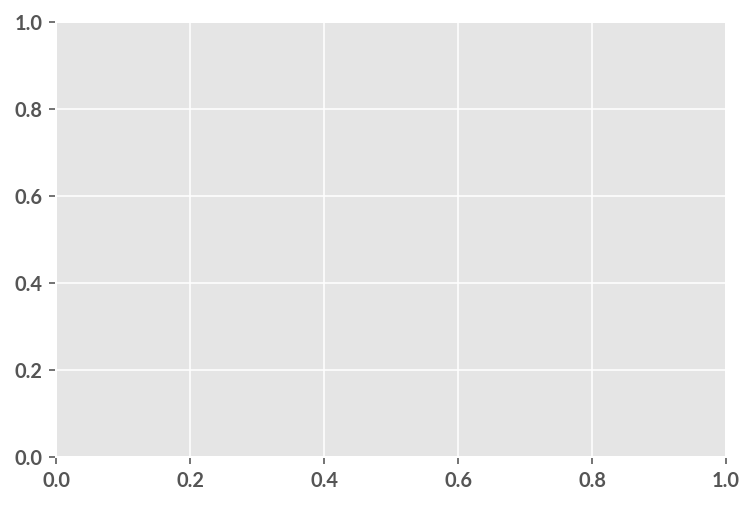

In [136]:
fig, ax = plt.subplots()
type(ax)

# Introduction

## The Peace Officer Involved Shooting Annual Report (aka the OAG report)

State law requires the Office of the Attorney General (OAG) to summarize all of the officer-involved shooting reports it receives in an annual report published each spring. The Peace Officer Involved Shooting Annual Report, published by the OAG, provides a high-level summary of officer-involved shootings reported during a calendar year. Here are links to the OAG’s reports for the last four years:

- [The 2019 report](https://www.texasattorneygeneral.gov/sites/default/files/files/divisions/criminal-justice/2019_Annual_Report.pdf)
- [The 2018 report](https://www.texasattorneygeneral.gov/sites/default/files/files/divisions/criminal-justice/Officer-Involved-Shootings-2018-Annual-Report.pdf)
- [The 2017 report](https://www.texasattorneygeneral.gov/sites/default/files/files/divisions/criminal-justice/OfficerInvolvedShootingsAnnualReport2017.pdf)
- [The 2016 report](https://www.texasattorneygeneral.gov/sites/default/files/files/divisions/criminal-justice/OfficerInvolvedShootingsAnnualReport2016.pdf)

The reports have the following information:

1. Civilians who are shot by peace officers
    - The number of civilians who died and got injured
    - Race demographics: white, black, hispanic, asian/pacific islanders, others, N/A
    - The number of civilians who carried a deadly weapon (the type of deadly weapon used is not provided).
    - The number of shootings that occurred per the type of call that officers were responding to (Note: a single incident can have more than one call type):
        1. Emergency Calls or Requests for Assistance
        2. Execution of a Warrant
        3. Hostage, Barricade and Other Emergency Situations
        4. Traffic Stops
        5. Other Uncategorized Situations
2. The number of officers who died and got injured


## The TJI datasets

We found that the datasets ("the TJI datasets") that OAG reports are based on have more information than what the OAG reports disclose. There are two datasets: one for the civlians who are shot by peace officers, and another for peace officers injured or killed in shootings.

1. Civilians who are shot by peace officers: each row of this dataset corresponds to a single civilian
    - Agency: name, location (city, county, zip code), email address of the peson who filed the report, report date, date that agency received the report, the number of reports filed
    - Civilian: name, demographics (race (white, black, hispanic, other), gender (male, female), age at the time of incident), whether they were injured or died, date of incident
    - Incident: time and date, location (city, county, zip code, address), whether civilian carried a deadly weapon, the reason of officers' involvement (the 5 categories the OAG reports use and more details in textual form)
    - Report: date that report was filed, whether the custodial death report was filed
    - Media: names of the news media which covered the incident
    - Officer: demographics (race, gender, age), details of the officer-caused injury (less than 10% of the data is populated), whether the officer was on duty, whether multiple officers were involved, the number of officers reported
    
2. Officers who died or got injured during the incident: each row of this dataset corresponds to a single officer
    - Agency: name, location, name of the person who filed the report, report date
    - Officer: name, demographics (race, gender, age), whether the officer died or got injured
    - Civilian: name, demographics (race, gender, age), whether the civilian died, got injured, or nothing happened to them, whether the civilian committed suicide
    - Incident: time and date, location
    - Media: links to media reports

You can download the csv files of both civilian and officer datasets at the TJI website.

# Preprocessing

To clean the csv datasets from the TJI websites, I have preprocessed the csv files with the following steps. See `1.0-hs-preprocess_officer_involved_shooting_data.ipynb` for more details.

1. Corrected the county names
    - Colin -> Collin
2. Removed the duplicates
    - The dataset does not have a unique identifier and thus I used the civilian full name and the date of incident to identify duplicates.
    - I found 3 incidents that have duplicates. These seem to be reports that were filed twice. I kept the most recent reports but deleted the rows with earlier reports assuming that the more recent reports may have more up-to-date information and fewer errors. 
3. Limited the rows to incidents that occurred between 2016 and 2019 period (4 years) because reporting was not required until September 2015.
4. Added a column that binarizes the death and injury of civilian data for convenience.
4. Cleaned the text from the incident causes (i.e., reasons of officers' involvement) for consistent analysis
    - Categorized `EMERGENCY` as `EMERGENCY CALL OR REQUEST FOR ASSISTANCE`
    - Categorized `OTHER - SPECIFY TYPE OF CALL` as `OTHER`
    - Created a separate binary column for each of the 5 incident categories
5. Discretized civilian age into bins based on the age groups that were used in the census data
    - 1-4, 5-14, 15-24, 25-34, 35-44, 45-54, 55-64, 65-74, 75+
6. Calculated the delay (number of days) between the date that an agency received the report and the date that the incident happened
    - I found one incident where the delay was negative values. I converted this value to N/A.
7. Discretized the delay from Step 7 into bins
    - Same Day, 1 to 7 Days, 8 to 14 Days, 15 to 30 Days, 31 to 60 Days, 61 to 90 Days, 91 to 180 Days, 181 to 360 Days, 361 to 720 Days, More than 720 Days

# Load datasets

## Shooting datasets
These two datasets are fully preprocessed. The below shows the size (no. rows, no. columns) in the civilian and officer datasets.

In [6]:
df_cd = pd.read_pickle('../Data/Preprocessed/civilian_shooting_preprocessed.pkl'); print(df_cd.shape)
df_os = pd.read_pickle('../Data/Preprocessed/officer_shooting_preprocessed.pkl'); print(df_os.shape)

(697, 154)
(130, 50)


First 5 rows of the civilian dataset.

In [7]:
df_cd.head()

,date_ag_received,date_incident,incident_address,incident_city,incident_county,incident_zip,incident_result_of,incident_call_other,civilian_name_first,civilian_name_last,...,month,died,Traffic Stop,Emergency/Request for Assistance,Execution of a Warrant,Hostage/Barricade/Other Emergency,Other,civilian_age_binned,delay_days,delay_bin_label
66,NaT,2016-01-02,2000 LAMAR STREET,SWEETWATER,NOLAN,79556.0,EMERGENCY CALL OR REQUEST FOR ASSISTANCE,"SUSPECT INVOLVED IN HOMICIDE IN NOLAN COUNTY, ...",LANCE,LIGHT,...,1,True,0,1,0,0,0,5,NaN,-1
67,NaT,2016-01-03,FM 2932 & FM 741,UNINCORPORATED,KAUFMAN,75126.0,OTHER - SPECIFY TYPE OF CALL,OFF DUTY - ATTEMPTED TO ASSIST MOTORIST,CODY,WESBERRY,...,1,False,0,0,0,0,1,2,NaN,-1
68,NaT,2016-01-04,1142 BURGER STREET,ABILENE,TAYLOR,79603.0,EMERGENCY CALL OR REQUEST FOR ASSISTANCE,NaN,DEREK LEE,CASEY,...,1,False,0,1,0,0,0,3,NaN,-1
69,NaT,2016-01-17,5639 OLD HWY 90 W,SAN ANTONIO,BEXAR,78227.0,EMERGENCY CALL OR REQUEST FOR ASSISTANCE,NaN,ASHTON LANE,MORRIS,...,1,True,0,1,0,0,0,3,NaN,-1
70,NaT,2016-01-19,1100 RIVERWOOD,DALLAS,DALLAS,75217.0,OTHER - SPECIFY TYPE OF CALL,SUSPICIOUS PERSON,GARY WAYNE,JONES,...,1,True,0,0,0,0,1,4,NaN,-1


First 5 rows of the officer dataset.

In [8]:
df_os.head()

,date_ag_received,date_incident,incident_address,incident_city,incident_county,incident_zip,officer_harm,officer_name_first,officer_name_last,officer_age,...,civilian_name_last_3,civilian_age_3,civilian_race_3,civilian_gender_3,media_link_1,media_link_2,media_link_3,year,month,delay_days
5,NaT,2016-01-13,3100 ANITA,HOUSTON,HARRIS,77004,INJURY,KENNETH,FREGIA,46.0,...,NaN,NaN,NaN,NaN,CHRONICLE,ABC 13,NaN,2016,1,NaN
6,NaT,2016-01-19,6011 VAN ZANDT,HOUSTON,HARRIS,77016,INJURY,JASON,RHODES,33.0,...,NaN,NaN,NaN,NaN,CHRONICLE,CLICK2HOUSTON,NaN,2016,1,NaN
7,NaT,2016-02-07,1410 ASHLAND DRIVE,CONROE,MONTGOMERY,77385,INJURY,NaN,NaN,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,2,NaN
8,NaT,2016-02-22,5100 CLOVER,HOUSTON,HARRIS,77021,INJURY,NaN,NaN,27.0,...,NaN,NaN,NaN,NaN,CW39,HOUSTONTX.GOV,NaN,2016,2,NaN
9,2017-02-14,2016-03-01,508 SIMMONS DR.,EULESS,TARRANT,76040,DEATH,DAVID STEFAN,HOFER,29.0,...,NaN,NaN,NaN,NaN,DALLAS MORNING NEWS,NBC DFW,NaN,2016,3,350.0


## Census
We used census data to compare its race demographics against that from the civilian dataset.
### [2018 Estimated Population of Texas](https://demographics.texas.gov/Data/TPEPP/Estimates/)
Each row represents a county (254 counties in total).

In [9]:
df_census = pd.read_pickle('../Data/Interim/census_county_race_2010.pkl'); print(df_census.shape)
df_census_pct = preprocess.pct(df_census, axis=1)

(254, 4)


First 5 rows.

In [10]:
df_census.head()

,WHITE,BLACK,HISPANIC,OTHER
County,,,,
ANDERSON,34383,12472,10550,1574
ANDREWS,6794,206,11371,307
ANGELINA,55069,13751,20476,2391
ARANSAS,15716,244,6896,868
ARCHER,8238,40,933,248


### Mortality (2013, Texas DSHS)
- [Death counts by race, gender and age, 2013](https://www.dshs.texas.gov/chs/vstat/vs13/t26a.aspx)
    - All rates per 100k population
    - This dataset has race demographics (white, black, hispanic) and also has gender demographics. (male, female) 
    - I only focused on the **male** data mostly because the civilian dataset has very few female civilians.
- [Death counts by county, 2013](https://www.dshs.texas.gov/chs/vstat/vs13/t26b.aspx)
    - All rates per 1k Population
    - This dataset has race demographics (white, black, hispanic, other) but does not have gender distinction.
- Since we only used the census dataset to compute race demographics in proportion, we did not conver the unit in the original data into actual number of people.
- Note: `mortality_rate_by_age_male.csv` has age range <1 (newborns). We will not include when loading the dataset.

In [11]:
df_death_age_male = pd.read_csv('../Data/Raw/Census/mortality_rate_by_age_male.csv', index_col='Age').iloc[1:, :]; print(df_death_age_male.shape)
df_death_county = pd.read_csv('../Data/Raw/Census/mortality_rate_by_county.csv', index_col='County'); print(df_death_county.shape)

(9, 4)
(254, 5)


The first 5 rows of the mortality census data.

In [12]:
df_death_age_male.head()

,WHITE,BLACK,HISPANIC,TOTAL
Age,,,,
1-4,95,47,103,245
5-14,108,57,137,302
15-24,811,297,700,1808
25-34,1210,505,917,2632
35-44,1755,628,1199,3582


In [13]:
df_death_county.head()

,WHITE,BLACK,HISPANIC,OTHER,TOTAL
County,,,,,
ANDERSON,471,114,50,4,639
ANDREWS,81,3,23,1,108
ANGELINA,666,124,54,6,850
ARANSAS,300,4,43,6,353
ARCHER,77,0,1,0,78


## OAG reports

To create a csv file for the OAG reports, I read all 4 reports and summarized the numerical information from each report.

In [14]:
df_oag = pd.read_csv('../Data/Interim/OAG_report_summary.csv', index_col=0)
df_oag.columns = df_oag.columns.astype(int)
print(df_oag.columns.values)
print(df_oag.index.values)

[2016 2017 2018 2019]
['C-DEATH' 'C-INJURY' 'O-DEATH' 'O-INJURY' 'WHITE' 'BLACK' 'HISPANIC'
 'ASIAN' 'OTHER' nan 'DEADLY' 'NON_DEADLY' 'EMERGENCY CALL'
 'EXECUTION OF A WARRANT' 'HOSTAGE, BARRICADE AND OTHER EMERGENCY'
 'TRAFFIC STOP' 'OTHER']


- C-DEATH & C-INJURY: civlian death and injury
- O-DEATH & O-INJURY: officer death and injury
- WHITE, BLACK, HISPANIC, ASIAN, OTHER, nan: race demographics categorization in the OAG report
    - Since in the TJI dataset, there is no ASIAN or nan category, I included these two categories under `OTHER`
- DEADLY, NON_DEADLY: whether civilian carried a deadly weapon
- 'EMERGENCY CALL', 'EXECUTION OF A WARRANT','HOSTAGE, BARRICADE AND OTHER EMERGENCY', 'TRAFFIC STOP', 'OTHER': the 5 categories for incident causes

# 1. Preparation
For convenience, I defined commonly used variable names and datasets.
## Define commonly used variables

In [15]:
race_list = ['WHITE', 'BLACK', 'HISPANIC', 'OTHER']
incident_causes_list = ['Traffic Stop', 
                        'Emergency/Request for Assistance', 
                        'Execution of a Warrant', 
                        'Hostage/Barricade/Other Emergency', 
                        'Other']
years = range(2016, 2020)
age_range_names = df_death_age_male.index.values
print(age_range_names)

['1-4' '5-14' '15-24' '25-34' '35-44' '45-54' '55-64' '65-74' '75+']


## Defining commonly used dataframes for convenience

In [16]:
# civilians who got shot and died
df_cd_died = df_cd[df_cd['died']==1].copy()

# civilians who got shot in harris county
df_cd_harris = df_cd[df_cd['incident_county']=='HARRIS'].copy()

# counties with most incidents (top 5)
top5_locs = df_cd['incident_county'].value_counts()[:5].index.values
df_cd_top5 = df_cd.loc[df_cd['incident_county'].isin(top5_locs), :]
df_os_top5 = df_os.loc[df_os['incident_county'].isin(top5_locs), :]
print(top5_locs)

['HARRIS' 'BEXAR' 'DALLAS' 'TARRANT' 'TRAVIS']


**From this point, the numbering of the title** (e.g., **2**. TJI vs. OAG dataset) **corresponds to the numbering in [the google document](https://docs.google.com/document/d/1Q6fCI-UYxC7HPMxAyF7YidkZSZyamMD2wfxOyIXnUkQ/edit) I created.**

# 2. TJI vs. OAG dataset

In [17]:
df_oag.loc[['C-DEATH', 'C-INJURY'], :]

,2016,2017,2018,2019
C-DEATH,76,80,104,117
C-INJURY,90,78,70,82


In [18]:
df_cd.groupby('year')['date_incident'].count()

year
2016    176
2017    163
2018    173
2019    185
Name: date_incident, dtype: int64

In [19]:
df_oag_sum = df_oag.loc[['C-DEATH', 'C-INJURY'], :].sum(axis=0)
df_cd_sum = df_cd.groupby('year')['date_incident'].count()
df_oga_cd_sum = pd.concat([df_oag_sum, df_cd_sum], axis=1)
df_oga_cd_sum.columns = ['OAG', 'TJI']
display(df_oga_cd_sum)

,OAG,TJI
2016,166,176
2017,158,163
2018,174,173
2019,199,185


In [20]:
diffs = ['+{}'.format(diff) if diff>0 else str(diff) for diff in (df_cd_sum - df_oag_sum)]
print(diffs)

['+10', '+5', '-1', '-14']


Computing the average of annual difference as proportion

In [21]:
np.mean(abs(df_oga_cd_sum['OAG']-df_oga_cd_sum['TJI'])/df_oga_cd_sum['OAG'])*100

4.1996354676606575

## 2.1 Discrepancy between the OAG and TJI datasets: Civilian

Figure 1

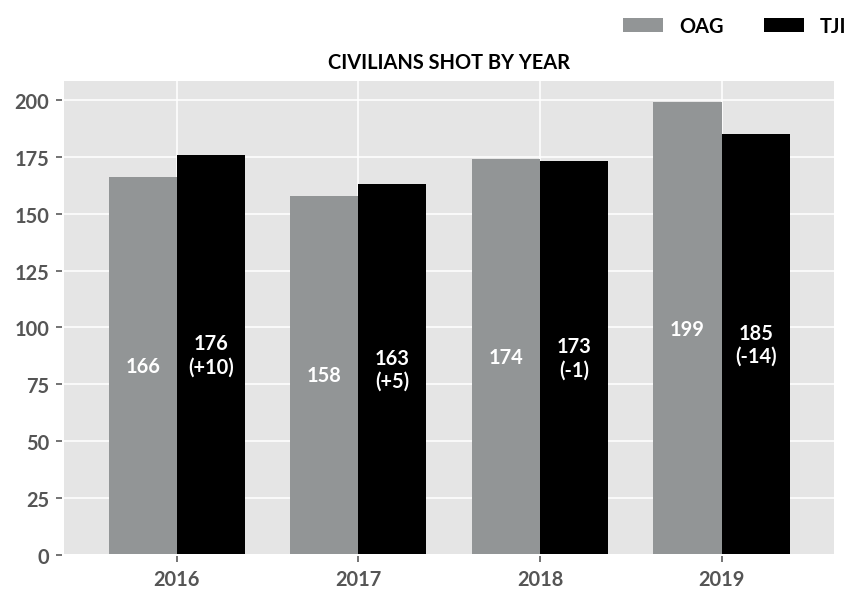

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

df_oga_cd_sum.plot.bar(width=0.75, color=cols_oag_tji, ax=ax, rot=0, legend=False)

# ax.legend(['OAG', 'TJI'], loc='upper left')
ax.set_xticklabels(years, fontsize=10)
ax.set(title='Civilians Shot by Year'.upper())

# annotating
for i, p in enumerate(ax.patches):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if i < 4:
        ax.text(x+width/2, y+height/2, '{:.0f}'.format(height), color='white', fontsize=10,
                horizontalalignment='center', verticalalignment='center')        
    else:
        ax.text(x+width/2, y+height/2, '{:.0f}\n({})'.format(height, diffs[i-4]), color='white', fontsize=10,
                horizontalalignment='center', verticalalignment='center')        

fig.legend(['OAG', 'TJI'], ncol=2, bbox_to_anchor=(1, 1.05), fontsize=10)
fig.tight_layout()
# fig.set_rasterized(True)
fig.savefig('../Figures/Figure_1.eps', bbox_inches='tight')

## 2.2 Discrepancy between the OAG and TJI datasets: Officer

In [25]:
df_oag_os_sum = df_oag.loc[['O-DEATH', 'O-INJURY'], :].sum(axis=0)
df_os_sum = df_os.groupby('year').count()['date_incident']
print(df_os_sum-df_oag_os_sum)

year
2016    0
2017    0
2018    1
2019    1
dtype: int64


# 3. The OAG data shows increase in the number of civilians shot every year.

## 3.1 2019 vs. 2017 and 2018

In [26]:
print(df_oag_sum.loc[2019]/df_oag_sum.loc[2017])
print(df_oag_sum.loc[2019]/df_oag_sum.loc[2018])

1.259493670886076
1.1436781609195403


## 3.2 No. deaths is increasing over time.

In [27]:
df_cd_year_died = df_cd.groupby(['year', 'civilian_died'])['date_incident'].count().unstack()
df_cd_year_died

civilian_died,DEATH,INJURY
year,,
2016,83,93
2017,83,80
2018,102,71
2019,108,77


In [28]:
df_cd_year_died.sum(axis=1)

year
2016    176
2017    163
2018    173
2019    185
dtype: int64

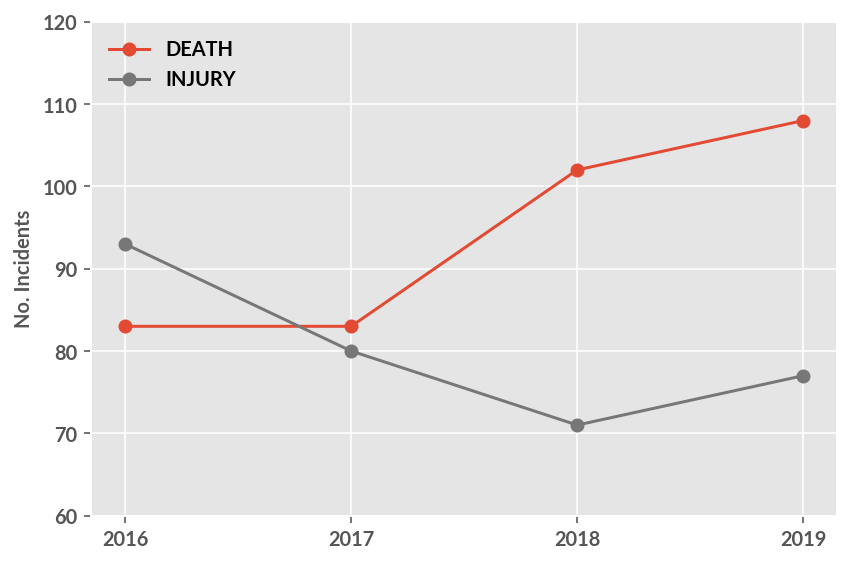

In [29]:
fig, ax = plt.subplots(1, 1)
df_cd_year_died.plot.line(marker='o', color=[colors[0],colors[3]], legend=False, rot=0, ylim=(60, 120), ax=ax)
ax.set_xticklabels(years, fontsize=10)
ax.set(ylabel='No. Incidents', xticks=years, xlabel='')
ax.legend(loc='upper left')
fig.tight_layout();

## 3.3 Survivability is decreasing over time.

$$Survival Rate (\%) = \dfrac{N_{Injured}} {N_{Shot}} * 100$$


Survivability = chance of getting injured instead of dying when inflicted with a gunshot

`preprocess.pct` convert absolute counts into percentages

In [30]:
??preprocess.pct

Signature: preprocess.pct(df, axis)
Docstring: <no docstring>
Source:   
def pct(df, axis):
    if axis == 1:
        return df.apply(lambda x: x/df.sum(axis=axis))*100
    if axis == 0:
        return df.apply(lambda x: x/df.sum(axis=axis), axis=1)*100
File:      ~/OneDrive - Arm/Projects/TJI_working_hshin/Notebooks/preprocess.py
Type:      function


In [31]:
df_cd_year_died

civilian_died,DEATH,INJURY
year,,
2016,83,93
2017,83,80
2018,102,71
2019,108,77


In [32]:
108/83

1.3012048192771084

In [33]:
df_cd_year_died_pct = preprocess.pct(df_cd_year_died, 1)
df_cd_year_died_pct

civilian_died,DEATH,INJURY
year,,
2016,47.16,52.84
2017,50.92,49.08
2018,58.96,41.04
2019,58.38,41.62


From 52.8% in 2016 to 41.6% in 2019

Plotting survival rate and counts together:

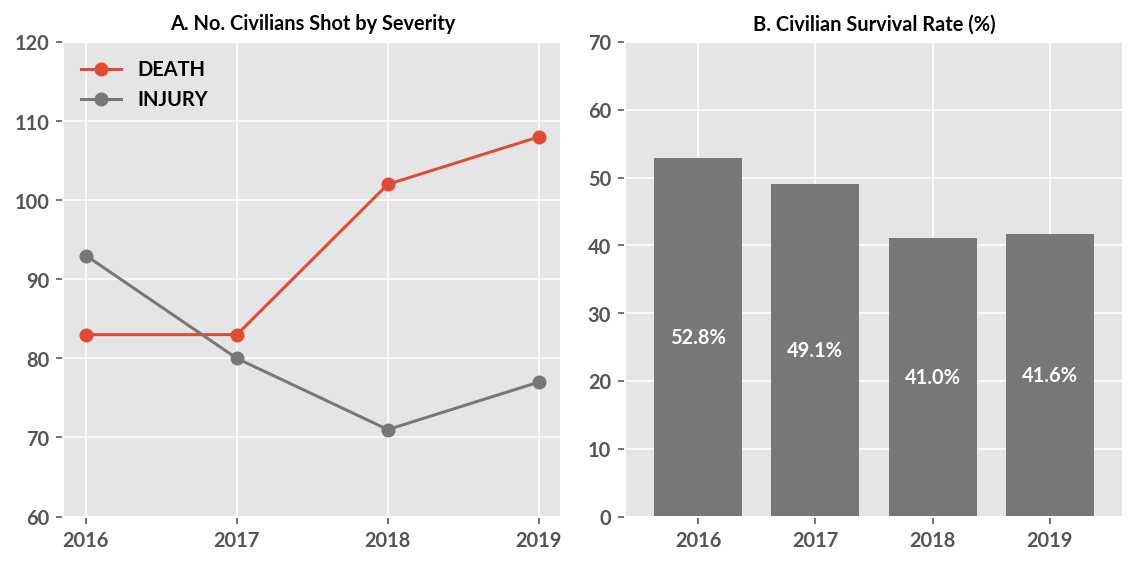

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
df_cd_year_died.plot.line(marker='o', color=[colors[0],colors[3]], legend=False, rot=0, ylim=(60, 120), ax=axes[0])
axes[0].set_xticklabels(years, fontsize=10)
axes[0].set(title='A. No. Civilians Shot by Severity', xticks=years, xlabel='')
axes[0].legend(loc='upper left')

df_cd_year_died_pct['INJURY'].plot.bar(color=colors[3], legend=False, rot=0, ylim=(0, 70), ax=axes[1], width=0.75)
plot.annotate(axes[1], 'v', unit='percent', fontsize=10)
axes[1].set(title='B. Civilian Survival Rate (%)', xlabel='')
axes[1].set_xticklabels(years, fontsize=10)

fig.tight_layout();

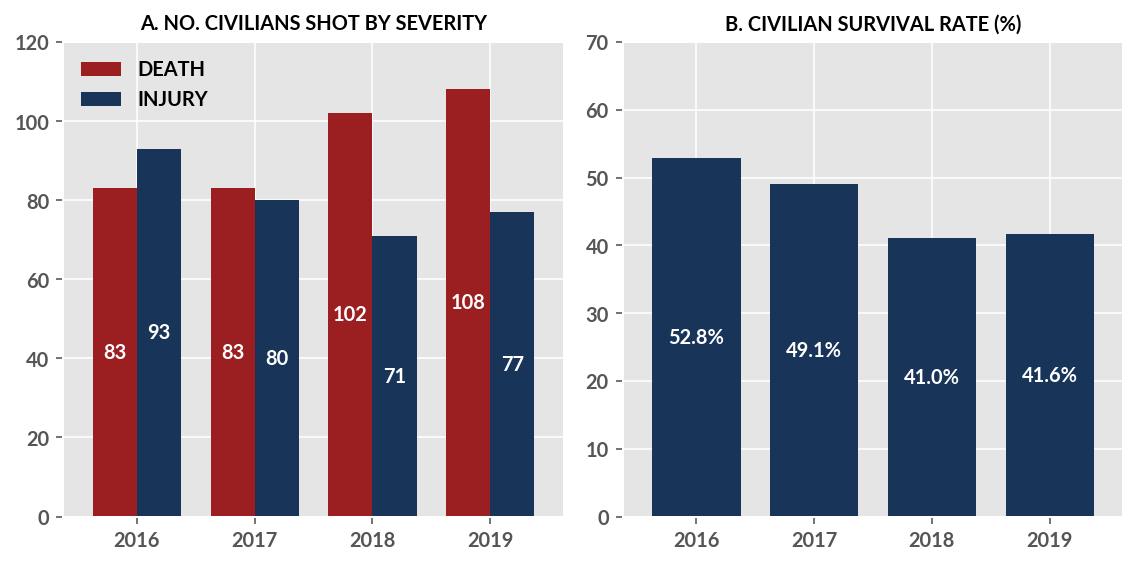

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
df_cd_year_died.plot.bar(color=cols_deaths_injury, legend=False, rot=0, ylim=(0, 120), width=0.75, ax=axes[0])

for i, p in enumerate(axes[0].patches):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    axes[0].text(x+width/2, y+height/2, '{:.0f}'.format(height), color='white', fontsize=10,
                 horizontalalignment='center', verticalalignment='center')        
axes[0].set(title='A. No. Civilians Shot by Severity'.upper(), xlabel='')
axes[0].legend(loc='upper left')

df_cd_year_died_pct['INJURY'].plot.bar(color=cols_deaths_injury[1], legend=False, rot=0, ylim=(0, 70), ax=axes[1], width=0.75)
plot.annotate(axes[1], 'v', unit='percent', fontsize=10)
axes[1].set(title='B. Civilian Survival Rate (%)'.upper(), xlabel='')
axes[1].set_xticklabels(years, fontsize=10)

fig.tight_layout()
fig.savefig('../Figures/Figure_15.eps', bbox_inches='tight')

## 3.4 The majority data comes from the top 5 counties (TJI data)

`plot.annotate` adds text annotation to bar graphs (counts or percentages)

In [42]:
??plot.annotate

Signature:
plot.annotate(
    ax,
    direction='v',
    unit='num',
    color='white',
    fontsize=10,
    threshold=0,
)
Docstring: <no docstring>
Source:   
def annotate(ax, direction='v', unit='num', color='white', fontsize=10, threshold=0):
    
    if unit == 'num':
        s = '{:.0f}'
    elif unit == 'percent':
        s = '{:.1f}%'
    else:
        raise ValueError('unit should be "num" or "percent"')
    
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        
        if direction == 'v':
            target = height
        elif direction == 'h':
            target = width
        else:
            raise ValueError('direction should be "v" or "h"')
            
        if target > threshold:
            ax.text(x+width/2, y+height/2, s.format(target), color=color, fontsize=fontsize,
                    horizontalalignment='center', verticalalignment='center')
File:      ~/OneDrive - Arm/Projects/TJI_working_hshin/No

In [43]:
def plot_heatmap_county_race_year(df, df_type='civilian', n_county=10, figsize=(12, 3.5), annot_fontsize=10, 
                                  total_count_yticks=True, total_count_cols=True, total_count_xticks=True, cmap=None):

    race_list = ['WHITE', 'BLACK', 'HISPANIC', 'OTHER']
    years = range(2016,2020)
    topN = df['incident_county'].value_counts()[:n_county].index
    gb = df.groupby(['year', df_type + '_race', 'incident_county'])
    vmax = gb['date_incident'].count().max()
    
    if cmap is None:
        cmap = 'viridis'
    
    fig, axes = plt.subplots(1, len(years), figsize=figsize, sharey=True)
    for i, (ax, year) in enumerate(zip(axes, years)):
        temp = gb['date_incident'].count().unstack().loc[year].loc[:, topN].T
        
        missing_races = set(race_list) - set(temp.columns)
        if len(missing_races) > 0:
            for missing_race in missing_races:
                temp[missing_race] = np.nan
        temp = temp[race_list]
        sns.heatmap(temp, annot=True, annot_kws={"size": annot_fontsize}, cbar=False, fmt='.3g', cmap=cmap, vmin=0, vmax=vmax, ax=ax)
        ax.set(ylabel='', xlabel='')
        
        if total_count_cols:
            ax.set_title('{} ({})'.format(year, int(temp.sum().sum())), fontsize=10)
        else:
            ax.set_title(year, fontsize=10)

        if total_count_xticks:
            ax.set_xticklabels([s + '\n({})'.format(int(n)) for s, n in zip(race_list, temp.sum(axis=0))], rotation=0)
        else:
            ax.set_xticklabels(race_list, rotation=0)
            
    if total_count_yticks:
        temp = gb['date_incident'].count().unstack().loc[:, topN].T
        axes[0].set_yticklabels([s + ' ({})'.format(int(n)) for s, n in zip(temp.index, temp.sum(axis=1))])
        
    fig.tight_layout()

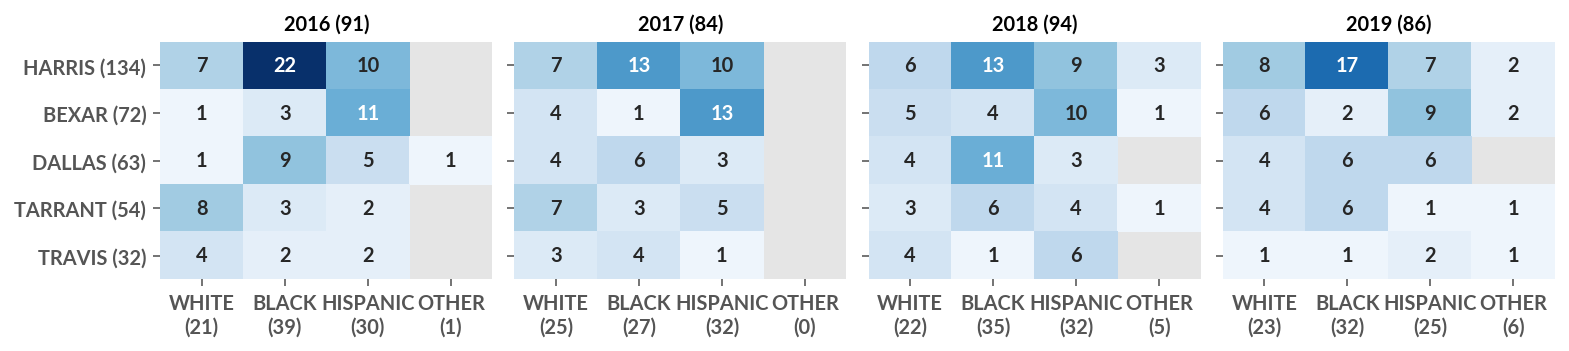

In [44]:
plot_heatmap_county_race_year(df_cd, n_county=5, figsize=(11, 2.5), cmap='Blues')

# 4. Officer vs. civilian survivability

## 4.1 Average survivability (state level)

In [45]:
df_cd_os_harm = pd.concat([df_cd['civilian_died'].value_counts(), df_os['officer_harm'].value_counts()], axis=1).T
df_cd_os_harm_pct = preprocess.pct(df_cd_os_harm, 1)

In [46]:
df_cd_os_harm

,DEATH,INJURY
civilian_died,376,321
officer_harm,22,108


In [47]:
df_cd_os_harm_pct

,DEATH,INJURY
civilian_died,53.95,46.05
officer_harm,16.92,83.08


Consistent with all 5 counties

In [48]:
df_cd_survival_top5_pct = preprocess.pct(df_cd_top5.groupby(['civilian_died', 'incident_county'])['date_incident'].count().unstack().fillna(0), 0)
df_os_survival_top5_pct = preprocess.pct(df_os_top5.groupby(['officer_harm', 'incident_county'])['date_incident'].count().unstack().fillna(0), 0)
df_survival_top5_pct = pd.concat([df_cd_survival_top5_pct.loc['INJURY', top5_locs], 
                                  df_os_survival_top5_pct.loc['INJURY', top5_locs]], axis=1)
df_survival_top5_pct.columns = ['Civilian', 'Officer']

In [49]:
df_cd_survival_top5_pct

incident_county,BEXAR,DALLAS,HARRIS,TARRANT,TRAVIS
civilian_died,,,,,
DEATH,52.78,55.56,44.78,51.85,65.62
INJURY,47.22,44.44,55.22,48.15,34.38


In [50]:
df_os_survival_top5_pct

incident_county,BEXAR,DALLAS,HARRIS,TARRANT,TRAVIS
officer_harm,,,,,
DEATH,15.38,31.58,9.38,22.22,0.0
INJURY,84.62,68.42,90.62,77.78,100.0


In [51]:
df_survival_top5_pct

,Civilian,Officer
incident_county,,
HARRIS,55.22,90.62
BEXAR,47.22,84.62
DALLAS,44.44,68.42
TARRANT,48.15,77.78
TRAVIS,34.38,100.00


## 4.2 Civilian survivability is decreasing over time.

In [52]:
civilian_survival_rate_by_year = preprocess.pct(df_cd.groupby(['civilian_died', 'year'])['date_incident'].count().unstack(), 0).loc['INJURY']
officer_survival_rate_by_year = preprocess.pct(df_os.groupby(['officer_harm', 'year'])['date_incident'].count().unstack(), 0).loc['INJURY']
survival_rate_by_year = pd.concat([civilian_survival_rate_by_year, officer_survival_rate_by_year], axis=1)
survival_rate_by_year.columns = ['Civilian', 'Officer']
survival_rate_by_year

,Civilian,Officer
year,,
2016,52.84,81.08
2017,49.08,80.77
2018,41.04,88.46
2019,41.62,82.93


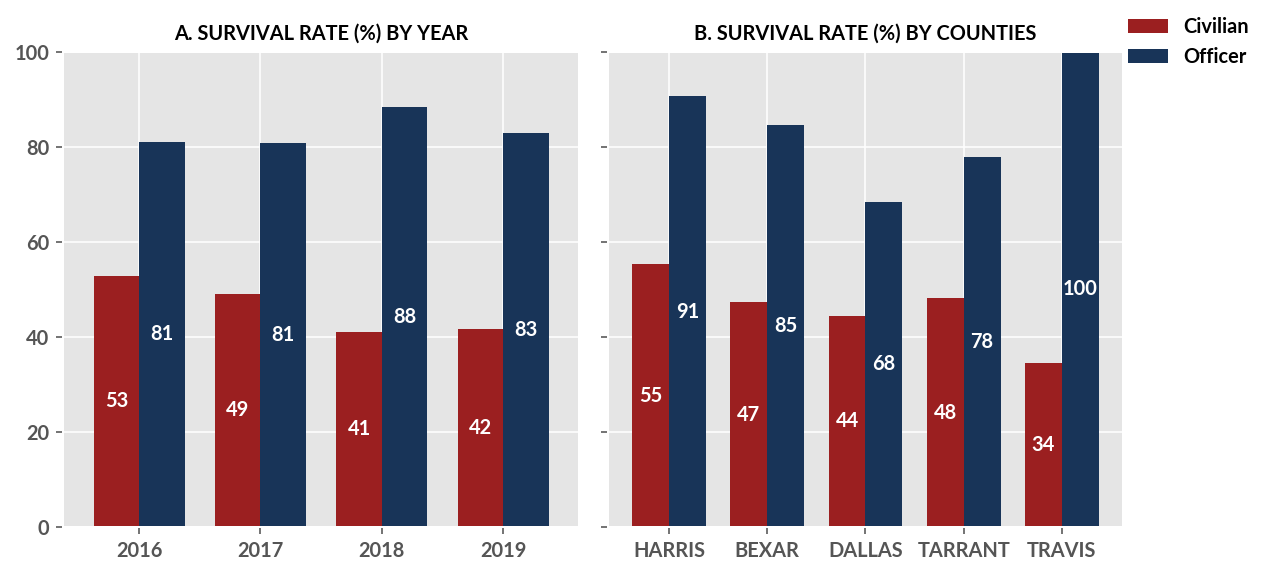

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

survival_rate_by_year.plot.bar(ax=axes[0], rot=0, legend=False, color=cols_civilian_officer, width=0.75)
plot.annotate(axes[0], 'v')
axes[0].set(ylim=(0, 100), xlabel=None, ylabel=None)
axes[0].set_xticklabels(years, fontsize=10)

topN = df_cd['incident_county'].value_counts()[:5].index
temp_cd = df_cd.groupby(['civilian_died', 'incident_county'])['date_incident'].count().unstack().loc[:, topN].T
temp_os = df_os.groupby(['officer_harm', 'incident_county'])['date_incident'].count().unstack().loc[:, topN].T
survival_rate_top5 = pd.concat([temp_cd['INJURY']/temp_cd.sum(axis=1)*100,
                                temp_os['INJURY']/temp_os.sum(axis=1)*100], axis=1)
survival_rate_top5.columns = ['Civilian', 'Officer']
survival_rate_top5.plot.bar(rot=0, width=0.75, ax=axes[1], color=cols_civilian_officer, legend=False)
plot.annotate(axes[1], 'v')

axes[0].set_title('A. Survival Rate (%) by Year'.upper())
axes[1].set_title('B. Survival Rate (%) by Counties'.upper())

fig.legend(['Civilian', 'Officer'], ncol=1, bbox_to_anchor=(1.1, 1), fontsize=10)
fig.tight_layout()
fig.savefig('../Figures/Figure_16.eps', bbox_inches='tight')

# 5. No. incidents and race demographics

## 5.1 All counties (state level) - majority white

In [54]:
df_cd_race_survival_year = df_cd.groupby(['civilian_race', 'civilian_died', 'year'])['date_incident'].count().unstack().fillna(0)
df_cd_race_survival_year

year                         2016  2017  2018  2019
civilian_race civilian_died                        
BLACK         DEATH          20.0  18.0  21.0  29.0
              INJURY         32.0  22.0  27.0  25.0
HISPANIC      DEATH          22.0  28.0  46.0  28.0
              INJURY         31.0  30.0  18.0  26.0
OTHER         DEATH           2.0   3.0   5.0   5.0
              INJURY          2.0   0.0   0.0   4.0
WHITE         DEATH          39.0  34.0  30.0  46.0
              INJURY         28.0  28.0  26.0  22.0

Example

In [55]:
df_cd_race_survival_year[2016].unstack().loc[race_list, :]

civilian_died,DEATH,INJURY
civilian_race,,
WHITE,39.0,28.0
BLACK,20.0,32.0
HISPANIC,22.0,31.0
OTHER,2.0,2.0


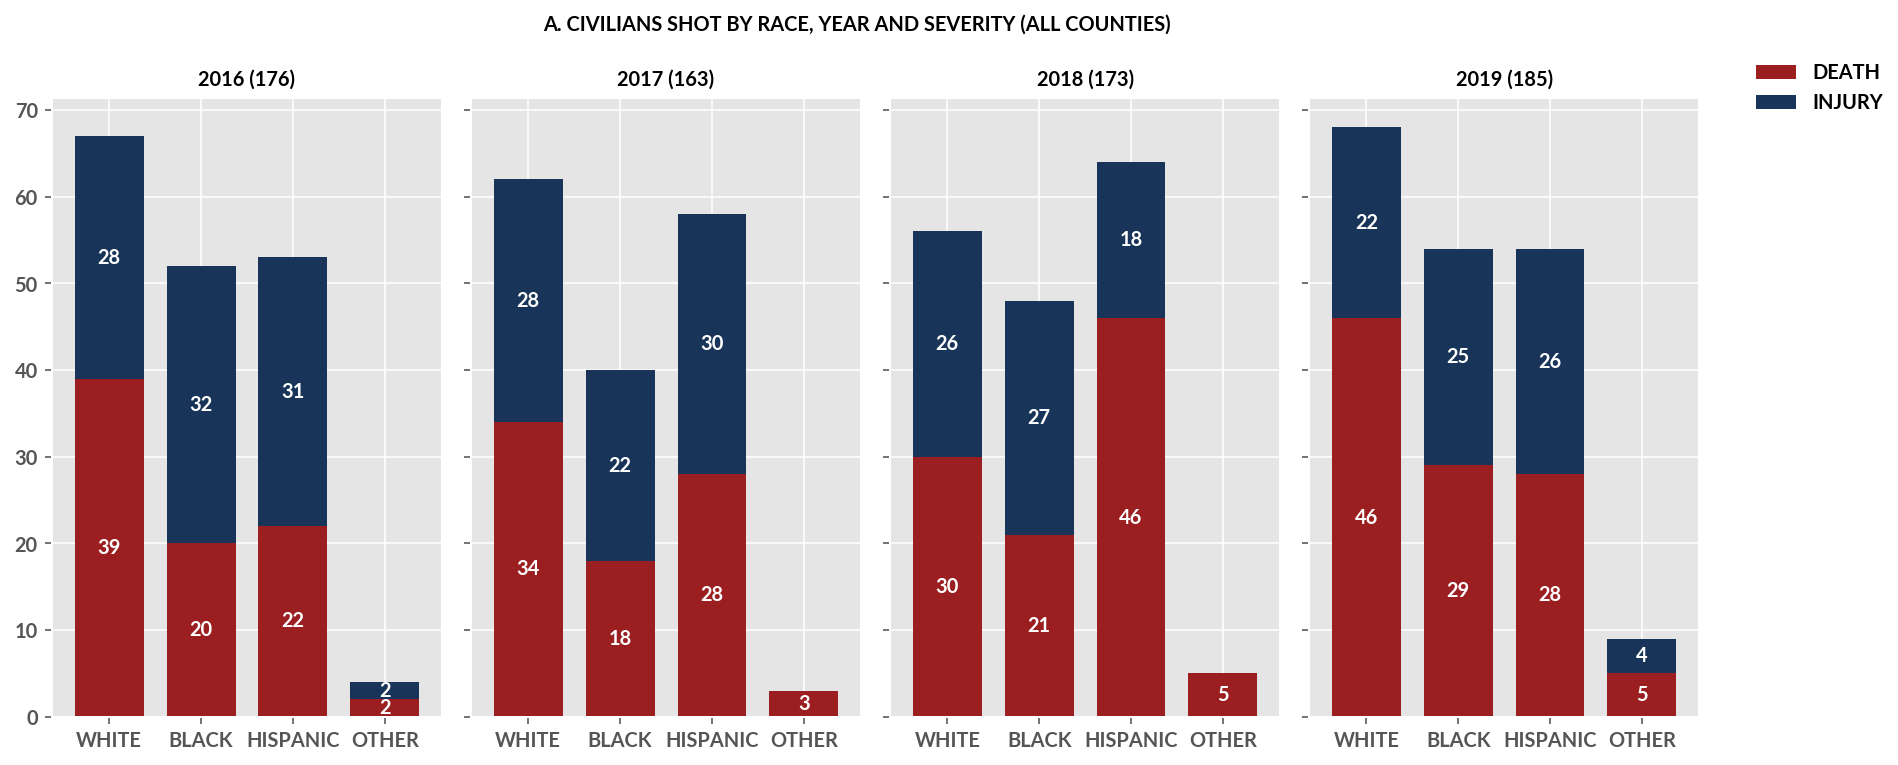

In [56]:
fig, axes = plt.subplots(1, len(years), figsize=(12, 5), sharey=True)

for i, (year, ax) in enumerate(zip(years, axes)):
    df_cd_race_survival_year[year].unstack().loc[race_list, :].plot.bar(
        stacked=True, color=cols_deaths_injury, legend=False, width=0.75, rot=0, ax=ax)
    plot.annotate(ax, 'v', fontsize=10)
    ax.set(xlabel='', title='{} ({})'.format(year, (df_cd['year']==year).sum()))

fig.suptitle('A. Civilians shot by race, year and severity (all counties)'.upper(), x=0.5, y=1.05)
fig.legend(['DEATH', 'INJURY'], ncol=1, bbox_to_anchor=(1.1, 1), fontsize=10)
fig.tight_layout()
fig.savefig('../Figures/Figure_17A.eps', bbox_inches='tight')

## 5.2 Metropolitan counties: majority non-white

In [57]:
df_cd_race_survival_year_top5 = df_cd_top5.groupby(['civilian_race', 'civilian_died', 'year'])['date_incident'].count().unstack().fillna(0)
df_cd_race_survival_year_top5

year                         2016  2017  2018  2019
civilian_race civilian_died                        
BLACK         DEATH          14.0  10.0  16.0  18.0
              INJURY         25.0  17.0  19.0  14.0
HISPANIC      DEATH          14.0  15.0  22.0  13.0
              INJURY         16.0  17.0  10.0  12.0
OTHER         DEATH           0.0   0.0   5.0   3.0
              INJURY          1.0   0.0   0.0   3.0
WHITE         DEATH          13.0  15.0   9.0  15.0
              INJURY          8.0  10.0  13.0   8.0

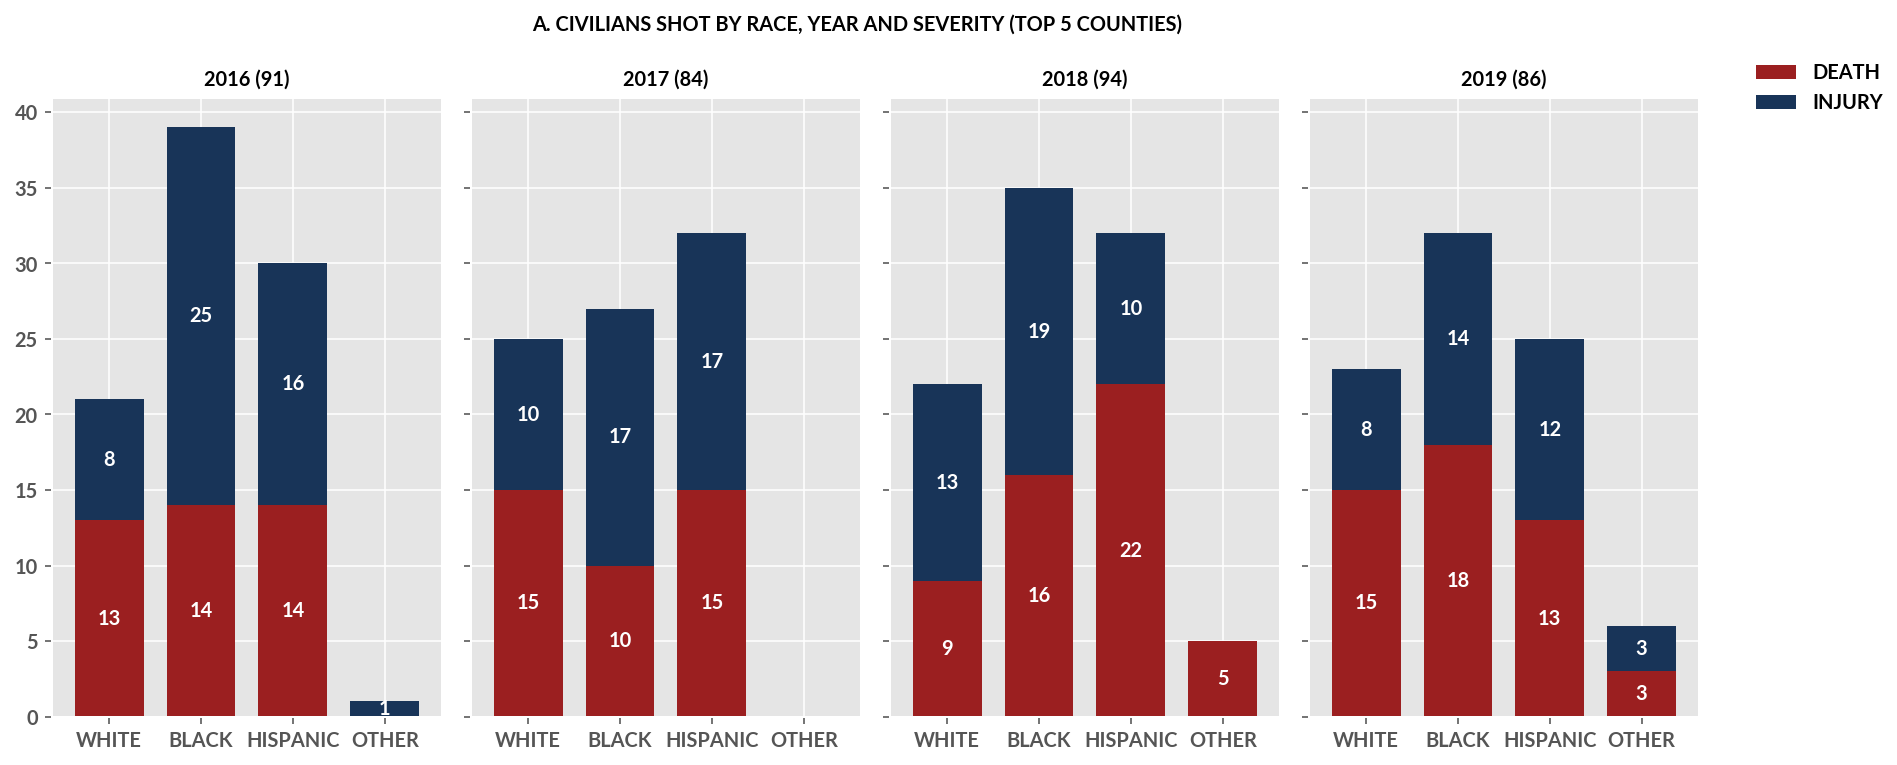

In [58]:
fig, axes = plt.subplots(1, len(years), figsize=(12, 5), sharey=True)

for i, (year, ax) in enumerate(zip(years, axes)):
    df_cd_race_survival_year_top5[year].unstack().loc[race_list, :].plot.bar(
        stacked=True, color=cols_deaths_injury, legend=False, width=0.75, rot=0, ax=ax)
    plot.annotate(ax, 'v', fontsize=10)
    ax.set(xlabel='', title='{} ({})'.format(year, df_cd_race_survival_year_top5[year].sum().astype(int)))

fig.suptitle('A. Civilians shot by race, year and severity (top 5 counties)'.upper(), x=0.5, y=1.05)
fig.legend(['DEATH', 'INJURY'], ncol=1, bbox_to_anchor=(1.1, 1), fontsize=10)
fig.tight_layout()
fig.savefig('../Figures/Figure_17B.eps', bbox_inches='tight')

In [59]:
race_all = df_cd['civilian_race'].value_counts().loc[race_list]
race_top5 = df_cd_top5['civilian_race'].value_counts().loc[race_list]

In [60]:
race_all/race_all.sum()

WHITE       0.36
BLACK       0.28
HISPANIC    0.33
OTHER       0.03
Name: civilian_race, dtype: float64

In [61]:
race_top5/race_top5.sum()

WHITE       0.26
BLACK       0.37
HISPANIC    0.34
OTHER       0.03
Name: civilian_race, dtype: float64

## 5.3 Race demographics comparison: general population vs. civilians shot (metropolitan)

Sanity check

In [62]:
df_cd_top5.groupby(['incident_county', 'civilian_race'])['date_incident'].count().unstack().fillna(0).loc[top5_locs, race_list]

civilian_race,WHITE,BLACK,HISPANIC,OTHER
incident_county,,,,
HARRIS,28,65,36,5
BEXAR,16,10,43,3
DALLAS,13,32,17,1
TARRANT,22,18,12,2
TRAVIS,12,8,11,1


In [63]:
preprocess.pct(df_cd_top5.groupby(['incident_county', 'civilian_race'])['date_incident'].count().unstack().fillna(0).loc[top5_locs, race_list], 1)

civilian_race,WHITE,BLACK,HISPANIC,OTHER
incident_county,,,,
HARRIS,20.90,48.51,26.87,3.73
BEXAR,22.22,13.89,59.72,4.17
DALLAS,20.63,50.79,26.98,1.59
TARRANT,40.74,33.33,22.22,3.70
TRAVIS,37.50,25.00,34.38,3.12


In [64]:
df_cd_race_county_top5_pct = preprocess.crosstab_by_topN_cities(df_cd, 'civilian_race', 'incident_county', N=5, ratio=True)*100
df_cd_race_county_top5_total = preprocess.crosstab_by_topN_cities(df_cd, 'civilian_race', 'incident_county', N=5, ratio=False)['TOTAL']
df_census_top5_pct = df_census_pct.loc[df_cd_race_county_top5_pct.index, :]

In [65]:
df_cd_race_county_top5_total

incident_county
HARRIS     134
BEXAR       72
DALLAS      63
TARRANT     54
TRAVIS      32
Name: TOTAL, dtype: int64

In [66]:
df_cd_race_county_top5_pct

civilian_race,WHITE,BLACK,HISPANIC,OTHER
incident_county,,,,
HARRIS,20.90,48.51,26.87,3.73
BEXAR,22.22,13.89,59.72,4.17
DALLAS,20.63,50.79,26.98,1.59
TARRANT,40.74,33.33,22.22,3.70
TRAVIS,37.50,25.00,34.38,3.12


In [67]:
df_census_top5_pct

,WHITE,BLACK,HISPANIC,OTHER
incident_county,,,,
HARRIS,29.54,18.55,42.46,9.45
BEXAR,27.34,7.29,60.32,5.05
DALLAS,28.81,22.54,40.08,8.57
TARRANT,46.64,16.13,28.78,8.45
TRAVIS,48.10,8.14,34.62,9.14


In [68]:
??plot.plot_stackedbar_compare_ratio

Signature:
plot.plot_stackedbar_compare_ratio(
    df_ratio,
    df_ref_ratio,
    df_total,
    figsize=(12, 6),
    severity='Shot',
    legend=True,
    fname=None,
)
Docstring: <no docstring>
Source:   
def plot_stackedbar_compare_ratio(df_ratio, df_ref_ratio, df_total, figsize=(12, 6), severity='Shot', legend=True, fname=None):
    
    # plot horizontal stacked bar side by side
    # to compare the general population (df_ref_ratio: ratio) and the data of interest (df: count)
    
    assert np.equal(df_ratio.index.values, df_ref_ratio.index.values).sum() == df_ratio.shape[0]
    
    cols_race = ['#CE2827', '#3167AE', '#4C5151', '#B8BAB9']
    
    df_ratio = df_ratio.copy()
    df_ref_ratio = df_ref_ratio.copy()
    
    # compute the ratio for df (df_ref should be)
    if df_ratio.index.dtype == 'object':
        df_ratio.index = [s[0] + s[1:].lower() for s in df_ratio.index]
        df_ref_ratio.index = [s[0] + s[1:].lower() for s in df_ref_ratio.index]

    # plotting
    fig

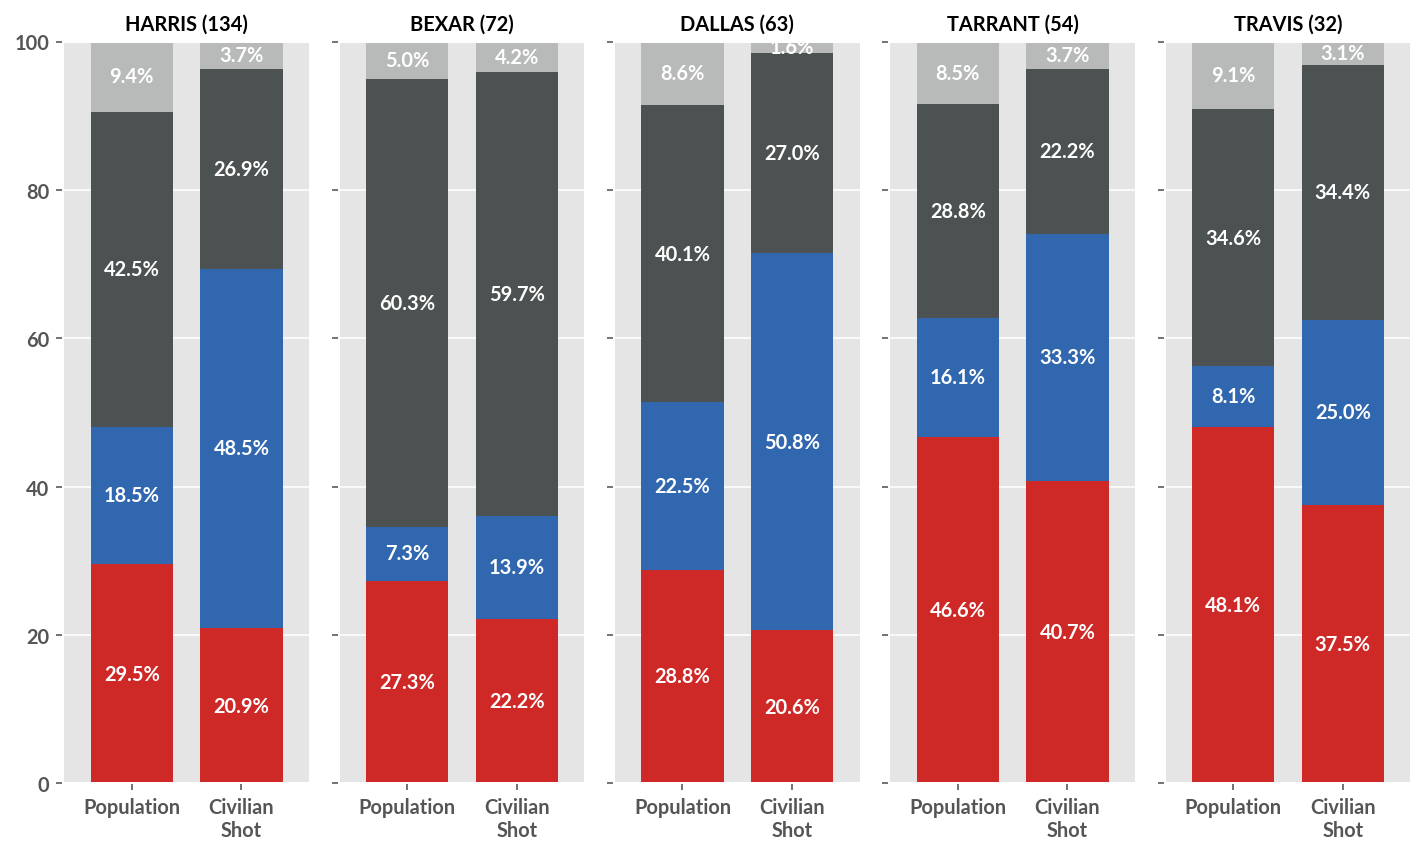

In [69]:
plot.plot_stackedbar_compare_ratio(df_cd_race_county_top5_pct, 
                                   df_census_top5_pct, 
                                   df_cd_race_county_top5_total, 
                                   legend=False,
                                   figsize=(10, 6),
                                   fname='../Figures/Figure_18.eps')

# 6. No. deaths and race demographics

## 6.1 Race demographics comparison (deceased): general population vs. civilians shot (metropolitan)

Female data is very sparse.

In [70]:
df_death_female = df_cd.loc[(df_cd['civilian_died']=='DEATH') & (df_cd['civilian_gender']=='FEMALE')]
df_cd_death_age_female = pd.crosstab(df_death_female['civilian_age_binned'], df_death_female['civilian_race']); df_cd_death_age_female

civilian_race,BLACK,HISPANIC,WHITE
civilian_age_binned,,,
2,0,1,1
3,2,1,6
4,2,2,3
5,0,1,4
6,0,0,3
7,0,0,1
8,0,1,0


In [71]:
df_cd_died['civilian_gender'].value_counts()/df_cd_died['civilian_gender'].value_counts().sum()

MALE      0.93
FEMALE    0.07
Name: civilian_gender, dtype: float64

Male only

In [72]:
df_death_county.loc[top5_locs, :]

,WHITE,BLACK,HISPANIC,OTHER,TOTAL
County,,,,,
HARRIS,12752,5698,4265,1277,23992
BEXAR,5469,980,5560,322,12331
DALLAS,8704,3985,1977,482,15148
TARRANT,8726,1514,1117,299,11656
TRAVIS,3424,538,863,137,4962


In [73]:
df_census_died_top5_pct = (preprocess.pct(df_death_county.drop('TOTAL', axis=1), 1)).loc[top5_locs, :]
df_cd_died_male = df_cd_died.loc[df_cd['civilian_gender']=='MALE', :]
df_cd_died_male_top5 = df_cd_died_male.groupby(['incident_county', 'civilian_race'])['date_incident'].count().unstack().fillna(0).loc[top5_locs, race_list]
df_cd_died_male_top5_pct = preprocess.pct(df_cd_died_male_top5, 1)

In [74]:
df_census_died_top5_pct

,WHITE,BLACK,HISPANIC,OTHER
County,,,,
HARRIS,53.15,23.75,17.78,5.32
BEXAR,44.35,7.95,45.09,2.61
DALLAS,57.46,26.31,13.05,3.18
TARRANT,74.86,12.99,9.58,2.57
TRAVIS,69.00,10.84,17.39,2.76


In [75]:
df_cd_died_male_top5

civilian_race,WHITE,BLACK,HISPANIC,OTHER
incident_county,,,,
HARRIS,15.0,23.0,14.0,4.0
BEXAR,6.0,3.0,24.0,1.0
DALLAS,8.0,16.0,9.0,0.0
TARRANT,8.0,9.0,6.0,2.0
TRAVIS,6.0,4.0,7.0,1.0


In [76]:
df_cd_died_male_top5_pct

civilian_race,WHITE,BLACK,HISPANIC,OTHER
incident_county,,,,
HARRIS,26.79,41.07,25.00,7.14
BEXAR,17.65,8.82,70.59,2.94
DALLAS,24.24,48.48,27.27,0.00
TARRANT,32.00,36.00,24.00,8.00
TRAVIS,33.33,22.22,38.89,5.56


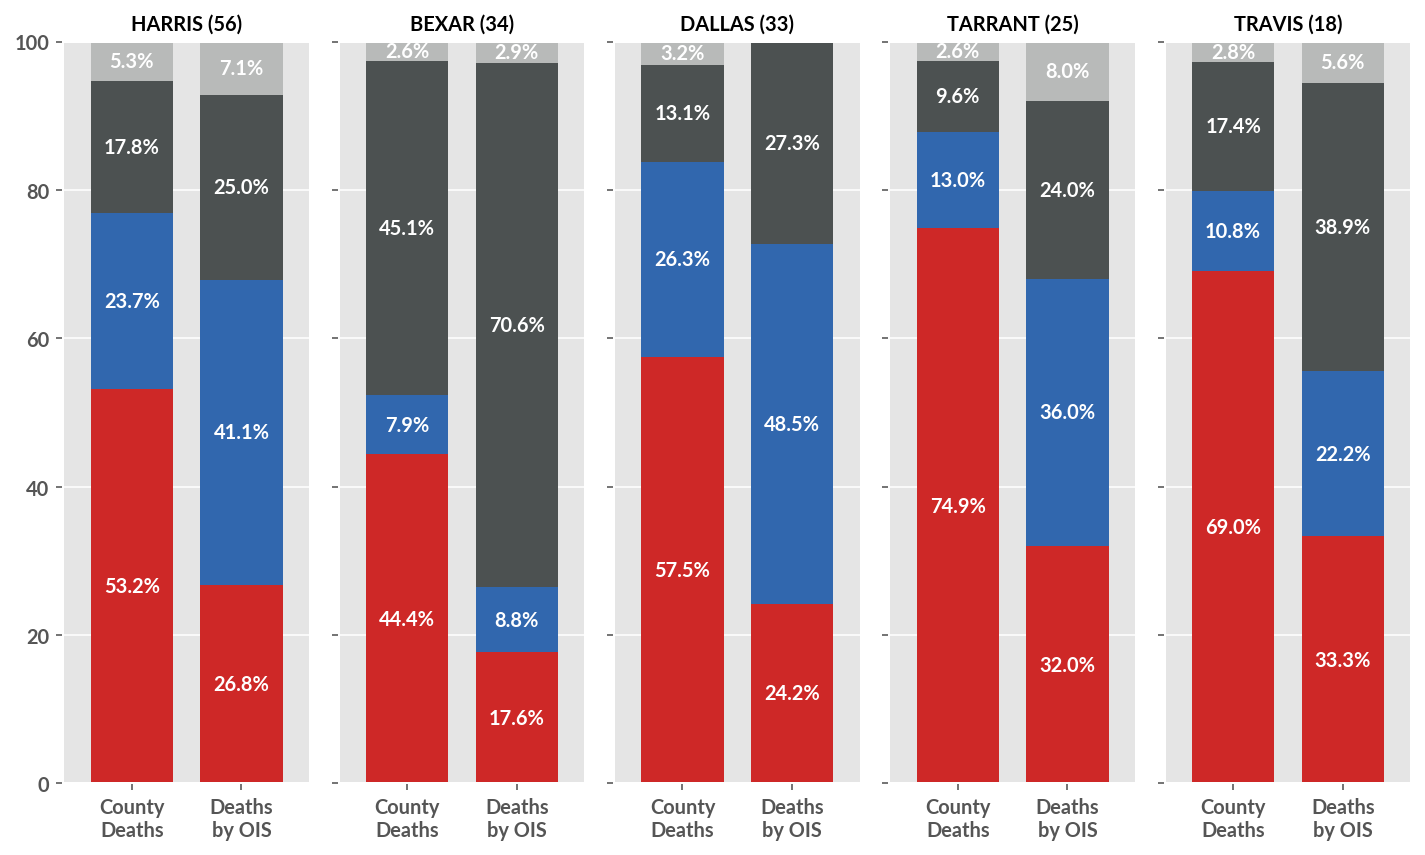

In [77]:
plot.plot_stackedbar_compare_ratio(df_cd_died_male_top5_pct,
                                   df_census_died_top5_pct,
                                   df_cd_died_male_top5.sum(axis=1).astype(int),
                                   severity='Deaths', 
                                   legend=False,
                                   figsize=(10, 6),
                                   fname='../Figures/Figure_19.eps')

# 7. Age at death and race demographics

## 7.1 Race demographics comparison (deceased): general population vs. civilians shot *per age group*

In [78]:
df_cd_died_male_age = df_cd_died.loc[df_cd_died['civilian_gender']=='MALE'].groupby(['civilian_age_binned', 'civilian_race'])['date_incident'].count().unstack().fillna(0)[race_list]
df_cd_died_male_age_pct = preprocess.pct(df_cd_died_male_age, 1)[race_list]

In [79]:
df_cd_died_male_age

civilian_race,WHITE,BLACK,HISPANIC,OTHER
civilian_age_binned,,,,
1,1.0,0.0,0.0,0.0
2,8.0,34.0,28.0,4.0
3,44.0,22.0,36.0,3.0
4,25.0,22.0,28.0,5.0
5,31.0,2.0,15.0,3.0
6,18.0,2.0,8.0,0.0
7,2.0,2.0,1.0,0.0
8,2.0,0.0,0.0,0.0
9,0.0,0.0,2.0,0.0


Sanity check

In [80]:
print(df_cd.loc[df_cd['civilian_age_binned']==2, 'civilian_age'].min())
print(df_cd.loc[df_cd['civilian_age_binned']==2, 'civilian_age'].max())

15.0
24.0


We're interested in age 15-24 to age 55-64 (decent sample size). This corresponds to index 2 to 6.

In [81]:
inds_age_binned = np.arange(2, 7)
df_cd_died_male_age_binned = df_cd_died_male_age.loc[inds_age_binned, :].drop('OTHER', axis=1)
df_death_age_male_binned = df_death_age_male.iloc[inds_age_binned, :].drop('TOTAL', axis=1)

In [82]:
df_cd_died_male_age_binned

civilian_race,WHITE,BLACK,HISPANIC
civilian_age_binned,,,
2,8.0,34.0,28.0
3,44.0,22.0,36.0
4,25.0,22.0,28.0
5,31.0,2.0,15.0
6,18.0,2.0,8.0


In [83]:
df_death_age_male.iloc[inds_age_binned, :].drop('TOTAL', axis=1)

,WHITE,BLACK,HISPANIC
Age,,,
15-24,811,297,700
25-34,1210,505,917
35-44,1755,628,1199
45-54,4788,1333,2449
55-64,9925,2435,3426


In [84]:
df_cd_died_male_age_binned_pct = preprocess.pct(df_cd_died_male_age_binned, 1)
df_death_age_male_binned_pct = preprocess.pct(df_death_age_male_binned, 1)

df_cd_died_male_age_binned_pct.index = ['Age {}'.format(s) for s in age_range_names[inds_age_binned]]
df_death_age_male_binned_pct.index = ['Age {}'.format(s) for s in age_range_names[inds_age_binned]]

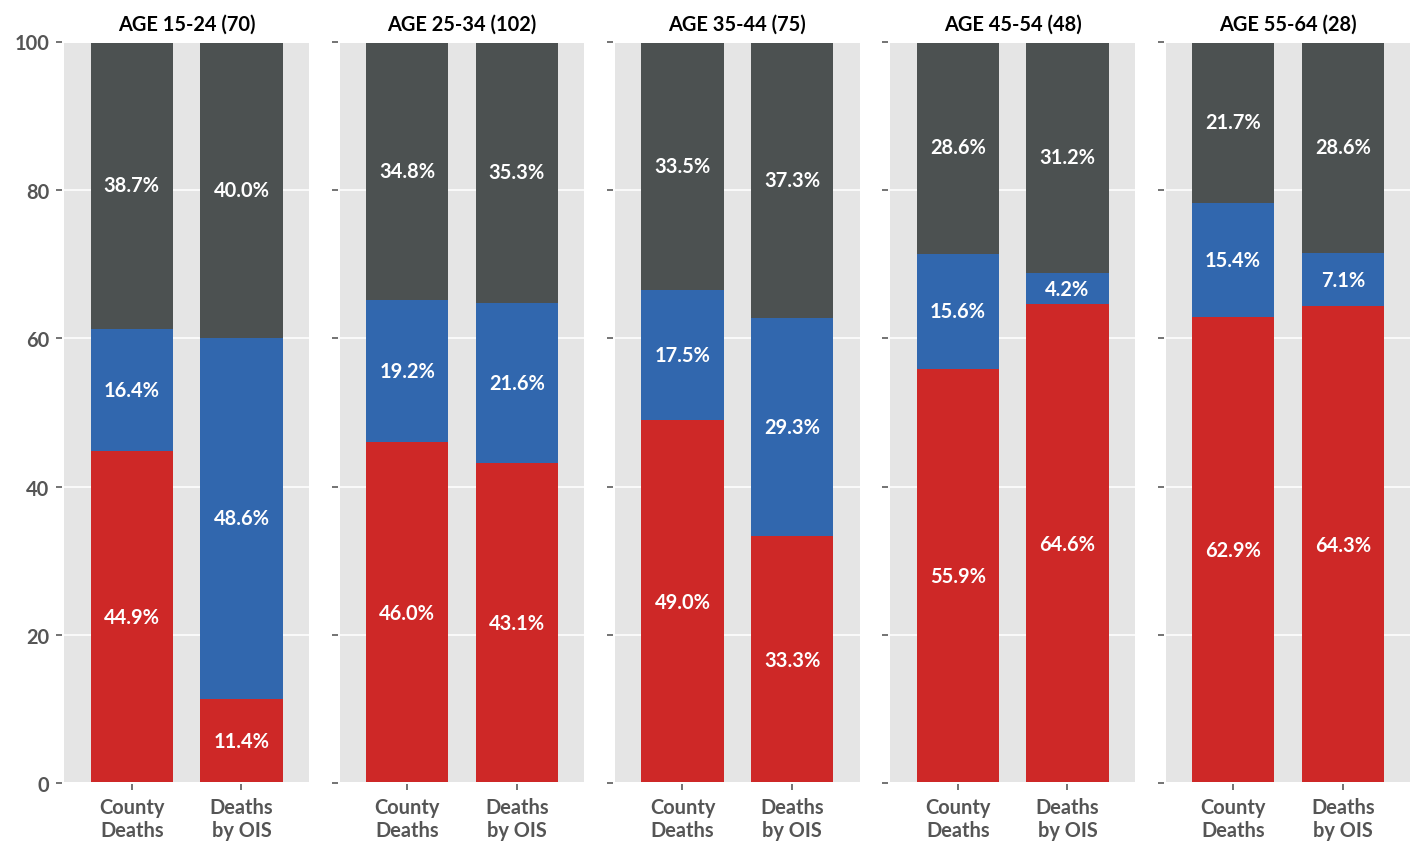

In [85]:
plot.plot_stackedbar_compare_ratio(df_cd_died_male_age_binned_pct,
                                   df_death_age_male_binned_pct,
                                   df_cd_died_male_age_binned.sum(axis=1).astype(int), 
                                   severity='Deaths', 
                                   legend=False,
                                   figsize=(10, 6),
                                   fname='../Figures/Figure_20.eps')

Sanity check: top5 counties

In [86]:
df_cd_died_male_age_top5 = df_cd_died.loc[(df_cd_died['civilian_gender']=='MALE') &
                                          (df_cd_died['incident_county'].isin(top5_locs))].groupby(['civilian_age_binned', 
                                                                                                    'civilian_race'])['date_incident'].count().unstack().fillna(0)[race_list]

In [87]:
df_cd_died_male_age_top5

civilian_race,WHITE,BLACK,HISPANIC,OTHER
civilian_age_binned,,,,
1,1.0,0.0,0.0,0.0
2,3.0,23.0,14.0,1.0
3,17.0,16.0,18.0,3.0
4,6.0,14.0,13.0,2.0
5,11.0,1.0,9.0,2.0
6,4.0,0.0,4.0,0.0
7,1.0,1.0,0.0,0.0
9,0.0,0.0,2.0,0.0


In [88]:
df_cd_died_male_age_top5_pct = preprocess.pct(df_cd_died_male_age_top5.drop('OTHER', axis=1).loc[2:5, :], 1)

In [89]:
df_cd_died_male_age_top5_pct.index = ['Age {}'.format(s) for s in age_range_names[2:6]]

Top 5 counties
Note that this may not be fair comparison because the death census data is at a state level.


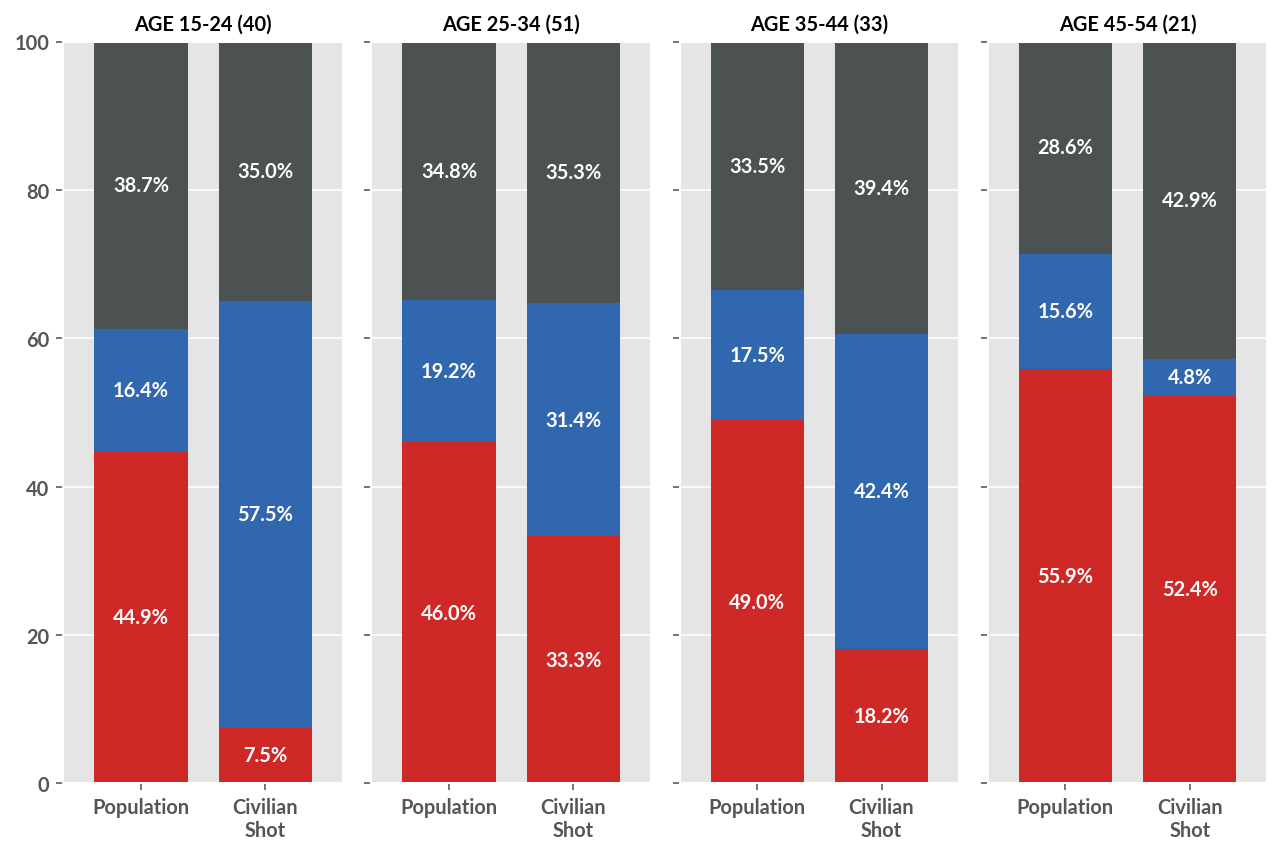

In [90]:
print('Top 5 counties')
print('Note that this may not be fair comparison because the death census data is at a state level.')
plot.plot_stackedbar_compare_ratio(df_cd_died_male_age_top5_pct,
                                   df_death_age_male_binned_pct.iloc[:-1],
                                   df_cd_died_male_age_top5.loc[2:5, :].drop('OTHER', axis=1).sum(axis=1).astype(int), legend=False,
                                   figsize=(9, 6))

## 7.2 Black youth death locations

In [91]:
df_cd_black_youth_died = df_cd.loc[(df_cd['civilian_age_binned']==2) & 
                                   (df_cd['civilian_race']=='BLACK') &
                                   (df_cd['civilian_gender']=='MALE') &
                                   (df_cd['died']==1), :]

In [92]:
inds_in_order = df_cd_black_youth_died['incident_county'].value_counts().index
df_cd_black_youth_count_died = df_cd_black_youth_died.groupby(['incident_county', 'year'])['date_incident'].count().unstack().fillna(0)

In [93]:
df_cd_black_youth_count_died.loc[inds_in_order]

year,2016,2017,2018,2019
HARRIS,2.0,1.0,2.0,3.0
TARRANT,0.0,2.0,2.0,4.0
TRAVIS,1.0,1.0,1.0,1.0
DALLAS,0.0,1.0,1.0,0.0
FORT BEND,0.0,0.0,0.0,2.0
BRAZORIA,0.0,0.0,0.0,1.0
WILBARGER,0.0,0.0,1.0,0.0
BEXAR,0.0,0.0,1.0,0.0
KIMBLE,0.0,0.0,0.0,1.0
PANOLA,1.0,0.0,0.0,0.0


In [94]:
df_cd_black_youth_count_died.sum().sum()

34.0

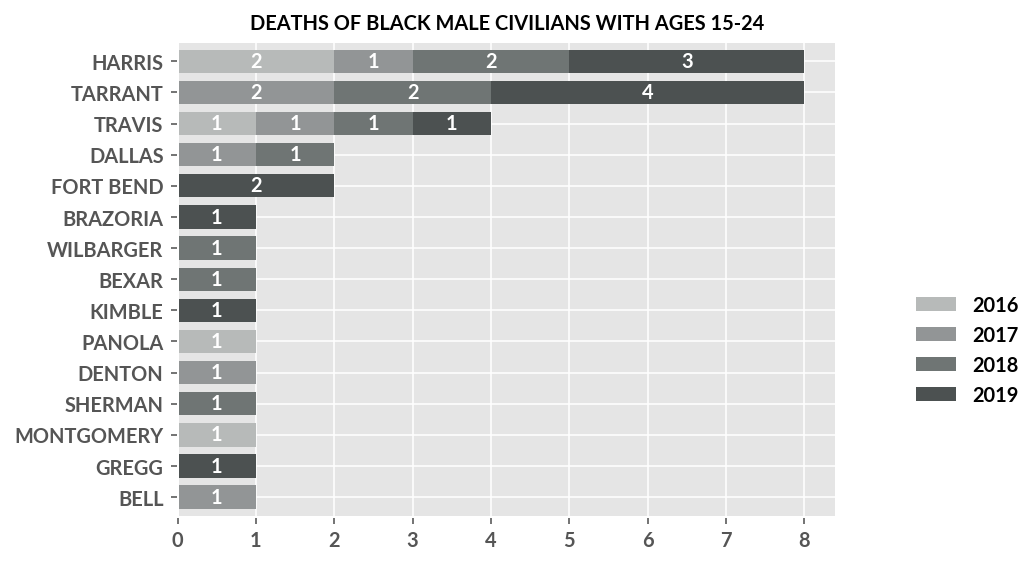

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
df_cd_black_youth_count_died.loc[inds_in_order[::-1], :].plot.barh(stacked=True, color=cols_year, width=0.75, ax=ax, legend=False)
plot.annotate(ax, 'h', threshold=0)
ax.set_title('Deaths of Black Male Civilians with Ages 15-24'.upper(), fontsize=10)

fig.tight_layout()
fig.legend(years, ncol=1, bbox_to_anchor=(1.2, 0.5), fontsize=10)
fig.savefig('../Figures/Figure_21.eps', bbox_inches='tight')

Sanity check

In [96]:
df_cd_black_youth_count_died_detail = df_cd_black_youth_died[['civilian_race', 
                                                              'civilian_died', 
                                                              'civilian_name_full', 
                                                              'civilian_age',
                                                              'incident_county']].sort_values(by='civilian_age')

In [97]:
df_cd_black_youth_count_died_detail.shape[0]

34

In [98]:
df_cd_black_youth_count_died_detail

,civilian_race,civilian_died,civilian_name_full,civilian_age,incident_county
308,BLACK,DEATH,JORDAN EDWARDS,15.0,DALLAS
301,BLACK,DEATH,DAEZION CHRISTIAN PAUL TURNER,15.0,BELL
695,BLACK,DEATH,ARIC RASHAD MOODY,16.0,HARRIS
303,BLACK,DEATH,KENDELL MARQUIS WILSON,16.0,HARRIS
82,BLACK,DEATH,DAVID JOSEPH,17.0,TRAVIS
716,BLACK,DEATH,BRANDON BELL,17.0,HARRIS
497,BLACK,DEATH,JESSE DARIAN CARRILLO,17.0,DALLAS
523,BLACK,DEATH,JALON GREGORY JOHNSON,17.0,HARRIS
224,BLACK,DEATH,ELIJAH MARK COBB,17.0,MONTGOMERY
709,BLACK,DEATH,AMARI MALONE,18.0,TARRANT


## 7.3 Age at death and race demographics

In [99]:
df_cd_died.groupby('civilian_race')['civilian_age'].median()[race_list]

civilian_race
WHITE       38.0
BLACK       29.0
HISPANIC    34.0
OTHER       37.0
Name: civilian_age, dtype: float64

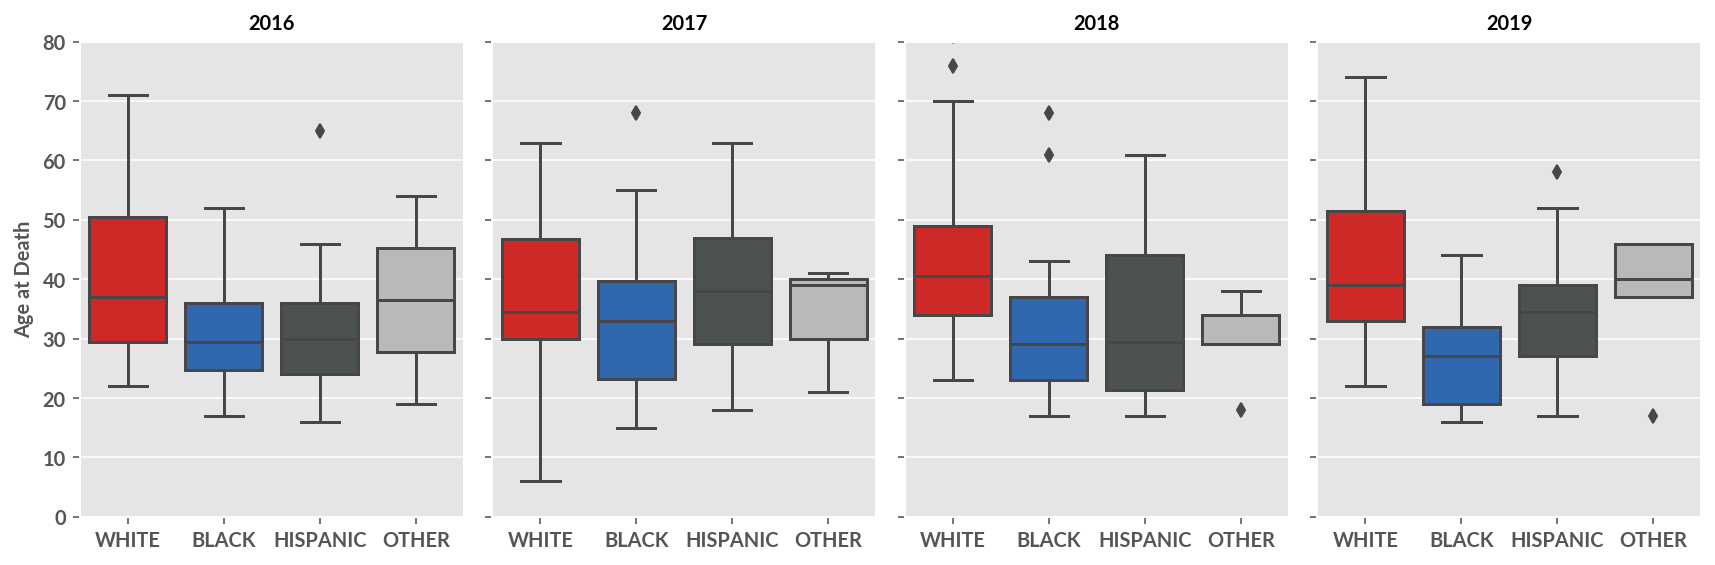

In [101]:
fig, axes = plt.subplots(1, len(years), figsize=(12, 4), sharey=True)
for i, (year, ax) in enumerate(zip(years, axes)):
    
    df_temp = df_cd_died[df_cd_died['year']==year]
    ax = sns.boxplot(x='civilian_race', y='civilian_age', data=df_temp, order=race_list, ax=ax)
    ax.set(ylim=(0, 80))
    if i == 0:
        ax.set_ylabel('Age at Death', fontsize=10)
    else:
        ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xticklabels(race_list, fontsize=10)
    ax.set_title(year, fontsize=10)
    
    for i, col in enumerate(cols_race):
        mybox = ax.artists[i]
        mybox.set_facecolor(col)
    
fig.tight_layout()
fig.savefig('../Figures/Figure_22.eps')

# 8. Deadly weapon

## 8.1 Survivability at state level

In [102]:
df_cd_deadly_died = df_cd.groupby(['deadly_weapon', 'died'])['date_incident'].count().unstack()
df_cd_deadly_died_pct = preprocess.pct(df_cd_deadly_died, 1)
df_cd_deadly_died

died,False,True
deadly_weapon,,
False,71,42
True,250,334


At a state level, when civilians possess deadly weapons, they have 42.8% of survival. If they don't, 62.8% of survivability.

In [103]:
df_cd_deadly_died_pct

died,False,True
deadly_weapon,,
False,62.83,37.17
True,42.81,57.19


## 8.2 Survivability decreases over time.

At a state level, the survivability of those who possesed the weapon decreased over time; 51.4% in 2016 to 40.0% in 2019.

In [104]:
df_cd[df_cd['deadly_weapon']==1].groupby(['year','civilian_died'])['date_incident'].count().unstack().fillna(0)

civilian_died,DEATH,INJURY
year,,
2016,70,74
2017,75,60
2018,93,52
2019,96,64


In [105]:
preprocess.pct(df_cd[df_cd['deadly_weapon']==1].groupby(['year','civilian_died'])['date_incident'].count().unstack().fillna(0), 1)['INJURY']

year
2016    51.39
2017    44.44
2018    35.86
2019    40.00
Name: INJURY, dtype: float64

## 8.3 Survivability between metropolitan counties than the other ares

In [106]:
print(df_cd[df_cd['incident_county'].isin(top5_locs)].groupby(['deadly_weapon','civilian_died'])['date_incident'].count().unstack().fillna(0))
print(df_cd[df_cd['incident_county'].isin(top5_locs)==False].groupby(['deadly_weapon','civilian_died'])['date_incident'].count().unstack().fillna(0))

civilian_died  DEATH  INJURY
deadly_weapon               
False             25      40
True             157     133
civilian_died  DEATH  INJURY
deadly_weapon               
False             17      31
True             177     117


In [107]:
preprocess.pct(df_cd[df_cd['incident_county'].isin(top5_locs)].groupby(['deadly_weapon','civilian_died'])['date_incident'].count().unstack().fillna(0), 1)

civilian_died,DEATH,INJURY
deadly_weapon,,
False,38.46,61.54
True,54.14,45.86


In [108]:
preprocess.pct(df_cd[~df_cd['incident_county'].isin(top5_locs)].groupby(['deadly_weapon','civilian_died'])['date_incident'].count().unstack().fillna(0), 1)

civilian_died,DEATH,INJURY
deadly_weapon,,
False,35.42,64.58
True,60.20,39.80


# 9. Incident causes

## 9.1 Categories

In [109]:
incident_causes_list

['Traffic Stop',
 'Emergency/Request for Assistance',
 'Execution of a Warrant',
 'Hostage/Barricade/Other Emergency',
 'Other']

In [110]:
incident_causes_list_sorted = df_cd[incident_causes_list].sum(axis=0).sort_values(ascending=False).index
print(incident_causes_list_sorted)

Index(['Emergency/Request for Assistance', 'Other', 'Traffic Stop',
       'Execution of a Warrant', 'Hostage/Barricade/Other Emergency'],
      dtype='object')


## 9.2 Frequency per category

In [111]:
df_cd[incident_causes_list_sorted].sum()

Emergency/Request for Assistance     386
Other                                176
Traffic Stop                          88
Execution of a Warrant                71
Hostage/Barricade/Other Emergency     37
dtype: int64

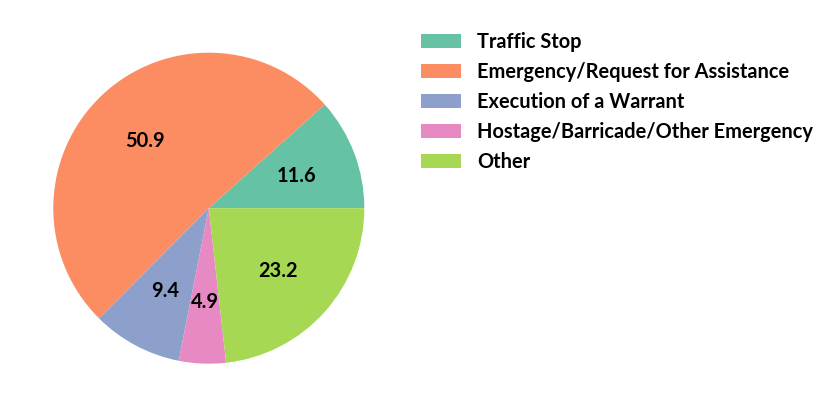

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
df_cd[incident_causes_list].sum().plot(kind='pie', autopct='%.1f', colors=colors_, labels=['','','','',''], ax=ax, fontsize=10)
ax.legend(incident_causes_list, bbox_to_anchor=(1, 0, 0.5, 1))
ax.set(ylabel='')
fig.tight_layout();

Sanity check: OAG data

In [113]:
df_oag_incident_cause_counts = df_oag.iloc[-5:, :].sum(axis=1).loc[['TRAFFIC STOP', 'EMERGENCY CALL', 'EXECUTION OF A WARRANT', 
                                                                    'HOSTAGE, BARRICADE AND OTHER EMERGENCY', 'OTHER']]

In [114]:
df_oag_incident_cause_counts

TRAFFIC STOP                               93
EMERGENCY CALL                            342
EXECUTION OF A WARRANT                     79
HOSTAGE, BARRICADE AND OTHER EMERGENCY     95
OTHER                                     184
dtype: int64

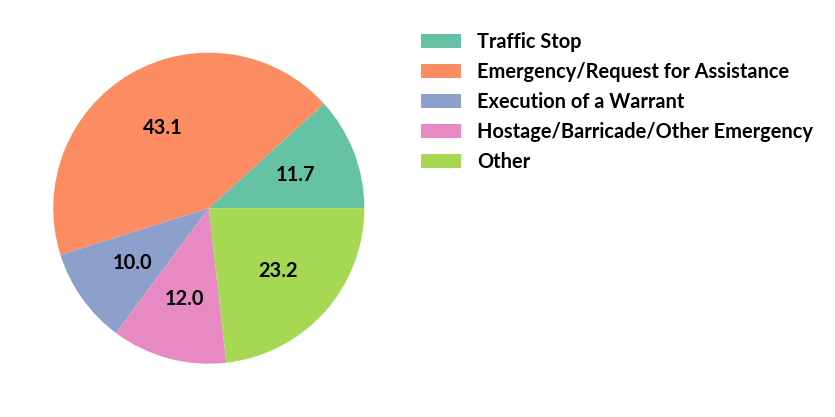

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
df_oag_incident_cause_counts.plot(kind='pie', autopct='%.1f', colors=colors_, labels=['','','','',''], ax=ax, fontsize=10)
ax.legend(incident_causes_list, bbox_to_anchor=(1, 0, 0.5, 1))
ax.set(ylabel='')
fig.tight_layout();

Our data is not too different from OAG data except that we have more "Emergency" causes and fewer "Hostage" causes.

In [116]:
df_oag_incident_cause_counts.values - df_cd[incident_causes_list].sum().values

array([  5, -44,   8,  58,   8])

## 9.3 Death is increasing for almost every category.

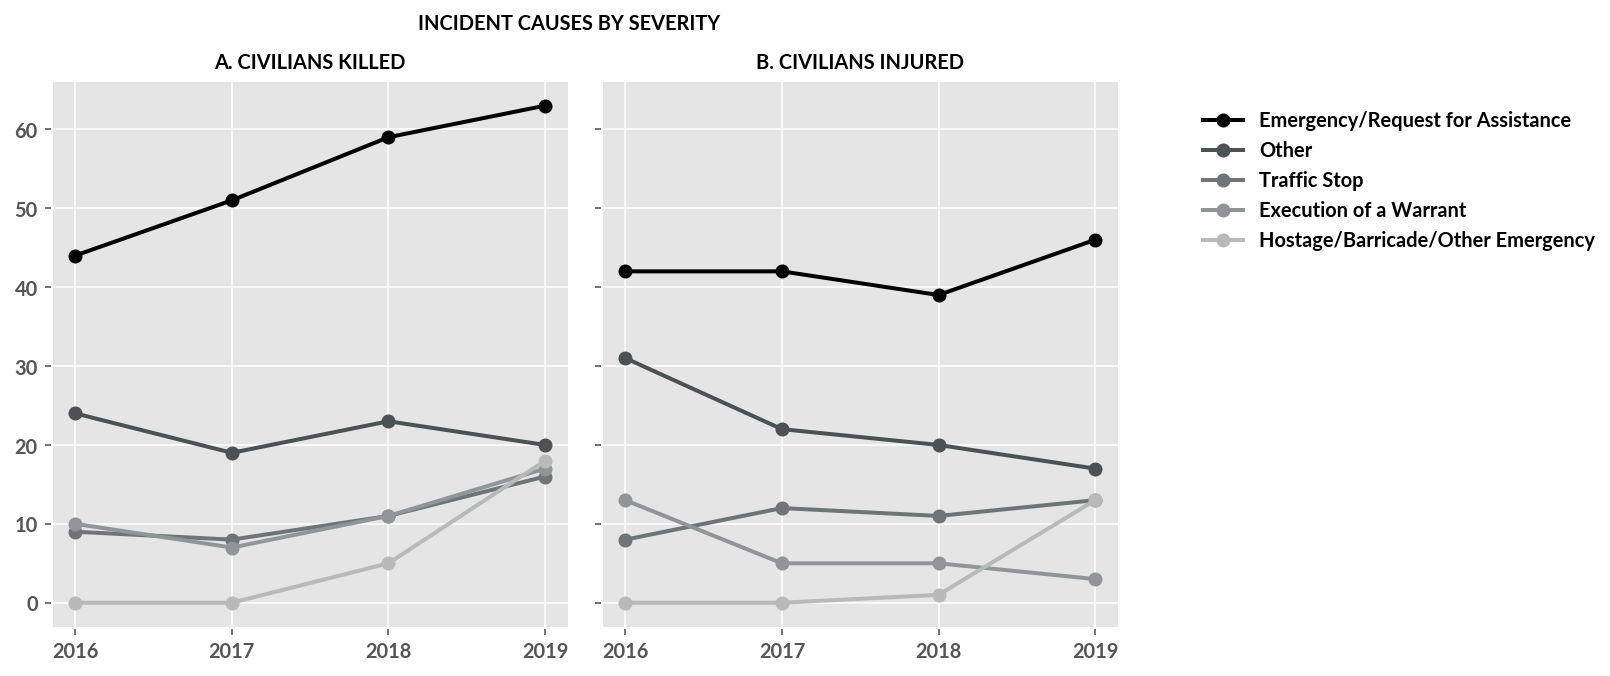

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4.5), sharey=True)
df_cd[df_cd['died']].groupby('year')[incident_causes_list_sorted].sum().plot(kind='line', color=cols_incident_causes, ax=axes[0], marker='o', lw=2, legend=False)
axes[0].set(xlabel='', xticks=years, xticklabels=years)
axes[0].set_title('A. Civilians killed'.upper(), fontsize=10)
df_cd[~df_cd['died']].groupby('year')[incident_causes_list_sorted].sum().plot(kind='line', color=cols_incident_causes, ax=axes[1], marker='o', lw=2, legend=False)
axes[1].set(xlabel='', xticks=years, xticklabels=years)
axes[1].set_title('B. Civilians injured'.upper(), fontsize=10)

fig.suptitle('Incident Causes by Severity'.upper(), fontsize=10, x=0.5, y=1.03)
fig.legend(incident_causes_list_sorted, ncol=1, bbox_to_anchor=(0.9, 0, 0.5, 0.9), fontsize=10)
fig.tight_layout()
fig.savefig('../Figures/Figure_23.eps', bbox_inches='tight')

## 9.4 The "Other" category

In [118]:
df_cd[incident_causes_list].sum()

Traffic Stop                          88
Emergency/Request for Assistance     386
Execution of a Warrant                71
Hostage/Barricade/Other Emergency     37
Other                                176
dtype: int64

## 9.5 Overrepresentation of "other" in non-white population (metropolitan)

In [119]:
df_cd_incident_race_top5 = df_cd_top5.groupby('civilian_race')[incident_causes_list_sorted].sum().loc[race_list, incident_causes_list_sorted]
df_cd_incident_race_top5_pct = preprocess.pct(df_cd_incident_race_top5, 0)
df_cd_incident_race_top5

,Emergency/Request for Assistance,Other,Traffic Stop,Execution of a Warrant,Hostage/Barricade/Other Emergency
civilian_race,,,,,
WHITE,54,17,9,10,7
BLACK,66,48,11,12,2
HISPANIC,67,32,11,10,4
OTHER,7,2,2,1,2


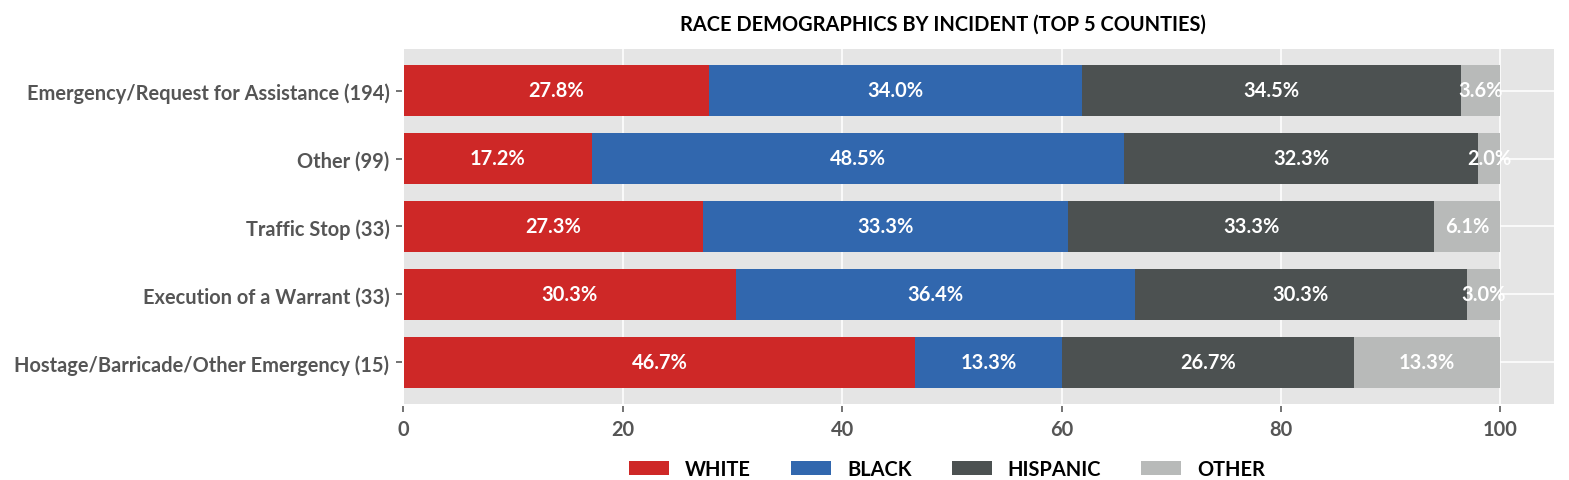

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(11, 3))
df_cd_incident_race_top5_pct.T[::-1].plot(kind='barh', stacked=True, ax=ax, legend=False, width=0.75, color=cols_race)
plot.annotate(ax, 'h', 'percent', fontsize=10)
ax.set_yticklabels([s + ' ({})'.format(n) for s, n in zip(df_cd_incident_race_top5.columns, 
                                                          df_cd_incident_race_top5.sum(axis=0).values)][::-1], fontsize=10)
fig.legend(race_list, ncol=4, bbox_to_anchor=(0.81, 0.09), fontsize=10)

fig.suptitle('Race demographics by incident (top 5 counties)'.upper(), fontsize=10, x=0.6, y=1.03)
fig.tight_layout()
fig.savefig('../Figures/Figure_24.eps', bbox_inches='tight')

# 10. Report delay

## 10.1 >30 day delay -> Illegal

## 10.2 Delay per year

In [121]:
df_cd['delay_bin_label'].unique()

array([-1,  7,  6,  2,  5,  3,  4,  1,  8,  0,  9])

In [122]:
bins = [0, 7, 14, 30, 60, 90, 180, 360, 720]
binnames = ['Same Day'] + ['{} to {} Days'.format(bins[i]+1, bins[i+1]) for i in range(len(bins)-1)] + ['More than 720 Days']
print(len(bins), len(binnames), binnames)

9 10 ['Same Day', '1 to 7 Days', '8 to 14 Days', '15 to 30 Days', '31 to 60 Days', '61 to 90 Days', '91 to 180 Days', '181 to 360 Days', '361 to 720 Days', 'More than 720 Days']


In [123]:
df_cd_delay_year = df_cd[(df_cd['delay_bin_label'] != -1) & (df_cd['year'] > 2016)].groupby(['delay_bin_label', 'year'])['date_incident'].count().unstack().fillna(0)
df_cd_delay_year

year,2017,2018,2019
delay_bin_label,,,
0,3.0,5.0,3.0
1,44.0,51.0,65.0
2,35.0,38.0,37.0
3,54.0,60.0,62.0
4,13.0,12.0,11.0
5,1.0,2.0,1.0
6,4.0,2.0,6.0
7,0.0,1.0,0.0
8,2.0,1.0,0.0


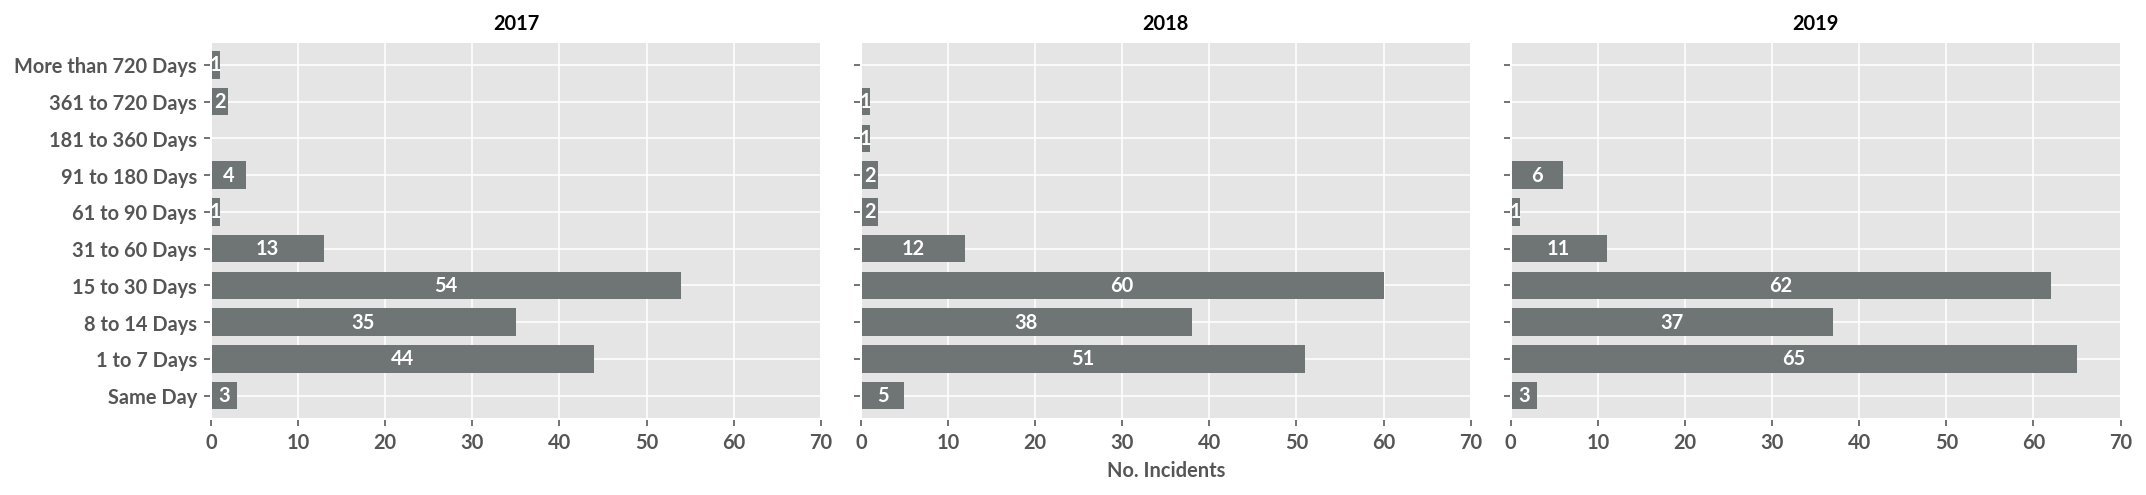

In [124]:
fig, axes = plt.subplots(1, len(years[1:]), figsize=(15, 3.5), sharey=True)
for i, (year, ax) in enumerate(zip(years[1:], axes)):
    
    df_cd_delay_year[year].plot(kind='barh', color=cols_bar, ax=ax, legend=False, width=0.75)
    ax.set(xlim=(0,70), ylabel='')
    ax.set_title(year, fontsize=10)
    if i == 1:
        ax.set(xlabel='No. Incidents')
    else:
        ax.set_xlabel(None)
    ax.set_yticklabels(binnames, fontsize=10)
    plot.annotate(ax, 'h', fontsize=10)
    
fig.tight_layout()
fig.savefig('../Figures/Figure_25.eps')

## 10.3 Counties with most number of delayed reports

In [125]:
df_cd['delayed_reports'] = df_cd['delay_days']>30
top5_locs_delays = df_cd[df_cd['delayed_reports']].groupby(['incident_county'])['date_incident'].count().sort_values(ascending=False)[:5].index
print(top5_locs_delays)

Index(['HARRIS', 'BEXAR', 'TARRANT', 'WEBB', 'ECTOR'], dtype='object', name='incident_county')


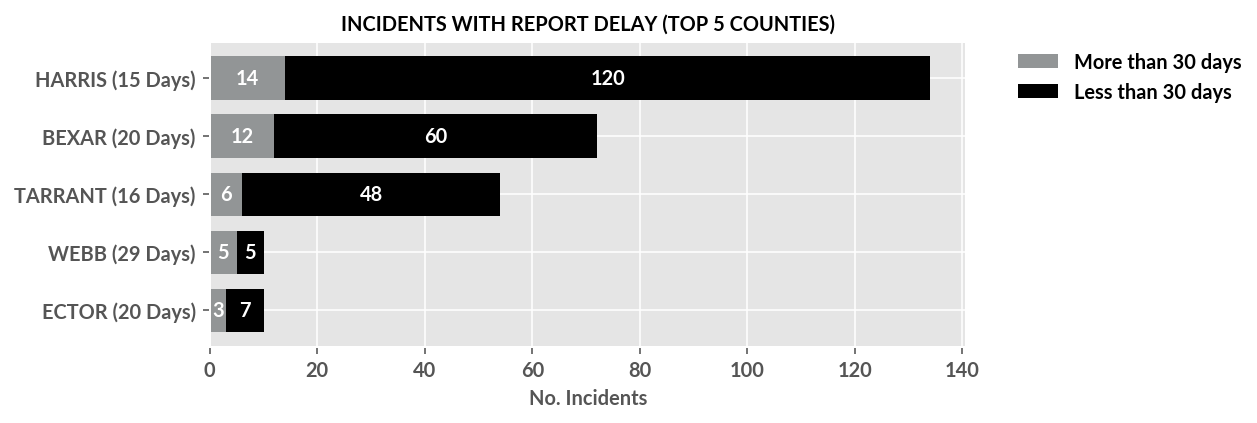

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))

df_cd_top5_delays = df_cd[df_cd['incident_county'].isin(top5_locs_delays)].groupby(['incident_county','delayed_reports'])['date_incident'].count().unstack()
df_cd_top5_delays.loc[top5_locs_delays, [1, 0]][::-1].plot.barh(stacked=True, legend=False, rot=0, color=cols_oag_tji, ax=ax, width=0.75)

medians = df_cd.groupby('incident_county')['delay_days'].median().loc[top5_locs_delays]
yticklabels = ['{} ({:.0f} Days)'.format(city, median) for city, median in medians.items()]

ax.set(xlabel='No. Incidents', ylabel='', yticklabels=yticklabels[::-1])
ax.set_title('incidents with report delay (top 5 counties)'.upper(), fontsize=10)
plot.annotate(ax, 'h', fontsize=10)

fig.legend(['More than 30 days', 'Less than 30 days'], bbox_to_anchor=(0.75, 0, 0.5, 0.9), fontsize=10)
fig.tight_layout()
fig.savefig('../Figures/Figure_26.eps', bbox_inches='tight')

In [127]:
df_cd.groupby('incident_county')['delay_days'].median().loc[top5_locs_delays]

incident_county
HARRIS     15.0
BEXAR      19.5
TARRANT    16.0
WEBB       29.0
ECTOR      20.5
Name: delay_days, dtype: float64

## 10.4 Officer vs. civilian delay

In [128]:
print(df_cd['delay_days'].median())
print(df_os['delay_days'].median())

14.0
21.0
